In [1]:
import sys, os, pygmt, importlib, re, time, glob, io
mod_path = '/home/581/da1339/AFIM/src/AFIM/src'
sys.path.insert(0, mod_path)
from sea_ice_toolbox         import SeaIceToolbox, SeaIceToolboxManager
from datetime                import timedelta, date, datetime
from pathlib                 import Path
from dask.distributed        import Client, LocalCluster
from dask.diagnostics        import ProgressBar
from pyproj                  import CRS, Transformer
from collections             import defaultdict
from scipy.interpolate       import interp1d
from tqdm                    import tqdm 
from matplotlib              import gridspec
from matplotlib.colors       import TwoSlopeNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker       import ScalarFormatter
from matplotlib.patches      import Rectangle, Circle
from IPython.display         import Image, HTML, Video
from pyproj                  import Transformer
from pyresample.geometry     import AreaDefinition, SwathDefinition
from pyresample.kd_tree      import resample_nearest
import numpy                 as np
import pandas                as pd
import xarray                as xr
import xesmf                 as xe
import matplotlib.pyplot     as plt
import matplotlib.dates      as mdates
import matplotlib.animation  as animation
import warnings
warnings.filterwarnings("ignore", message="Sending large graph of size", category=UserWarning, module="distributed.client")

In [43]:
import sys
import importlib
for mod in list(sys.modules):
    if mod.startswith("sea_ice_toolbox") or mod.startswith("sea_ice_"):
        del sys.modules[mod]
import sea_ice_plotter
import sea_ice_classification
import sea_ice_icebergs
import sea_ice_observations
import sea_ice_metrics
import sea_ice_toolbox
importlib.reload(sea_ice_plotter)
importlib.reload(sea_ice_classification)
importlib.reload(sea_ice_icebergs)
importlib.reload(sea_ice_observations)
importlib.reload(sea_ice_metrics)
importlib.reload(sea_ice_toolbox)
from sea_ice_toolbox import SeaIceToolbox, SeaIceToolboxManager

# Conceptual Model of Free-slip v No-slip

## helper functions

In [ ]:
def epm_from_cells(left_is_land, right_is_land):
    # E-edge exists only if both adjacent T cells are ocean
    return 0 if (left_is_land or right_is_land) else 1

def npm_from_cells(bottom_is_land, top_is_land):
    # N-edge exists only if both adjacent T cells are ocean
    return 0 if (bottom_is_land or top_is_land) else 1

def build_masks(land1, land2, land3, land4):
    c1, c2, c3, c4 = land1, land2, land3, land4
    epm = {
        "E(i,j)"    : epm_from_cells(c1, c4),
        "E(i+1,j)"  : epm_from_cells(c4, False),   # assume ocean outside to the right
        "E(i,j+1)"  : epm_from_cells(c2, c3),
        "E(i+1,j+1)": epm_from_cells(c3, False),
        "E(i,j+2)"  : epm_from_cells(c2, c3),      # mirror row above
        "E(i+1,j+2)": epm_from_cells(c3, False),
    }
    npm = {
        "N(i,j)"    : npm_from_cells(c1, c2),
        "N(i+1,j)"  : npm_from_cells(c4, c3),
        "N(i,j+1)"  : npm_from_cells(c2, False),   # assume ocean above
        "N(i+1,j+1)": npm_from_cells(c3, False),
    }
    return epm, npm

def build_masks_for_T(land1, land2, land3, land4):
    c1, c2, c3, c4 = land1, land2, land3, land4
    npm = {
        "N(i,j-1)"    : npm_from_cells(True,    c1),
        "N(i+1,j-1)"  : npm_from_cells(True,    c4),
        "N(i,j)"      : npm_from_cells(c1, c2),
        "N(i+1,j)"    : npm_from_cells(c4, c3),
        "N(i,j+1)"    : npm_from_cells(c2, True),
        "N(i+1,j+1)"  : npm_from_cells(c3, True),
    }
    epm = {
        "E(i-1,j)"    : epm_from_cells(True,   c1),
        "E(i-1,j+1)"  : epm_from_cells(True,   c2),
        "E(i,j)"      : epm_from_cells(c1, c4),
        "E(i,j+1)"    : epm_from_cells(c2, c3),
        "E(i+1,j)"    : epm_from_cells(c4, False),
        "E(i+1,j+1)"  : epm_from_cells(c3, False),
    }
    return epm, npm
    
def reflect(neigh_val, neigh_mask, self_val):
    # For free-slip: if neighbor masked, use self edge value (mirror); if both missing, 0.
    if neigh_mask == 1:
        return neigh_val
    return 0.0 if self_val is None else self_val

def shear_at_U_column(uE_down, m_down, uE_up, m_up, method):
    down_eff = uE_down if m_down == 1 else 0.0
    if method == "free-slip":
        up_eff = reflect(uE_up, m_up, down_eff)
    elif method == "no-slip":
        up_eff = uE_up if m_up == 1 else 0.0
    else:
        raise ValueError("method must be 'free-slip' or 'no-slip'")
    return up_eff - down_eff

def build_edge_velocities(land1, land2, land3, land4, flows):
    """
    Build per-edge velocities uE,vE and uN,vN from per-cell flows.
    Edge value = mean of available ocean neighbors; masked edges -> 0.
    """
    c1, c2, c3, c4 = land1, land2, land3, land4
    (U0,V0), (U1,V1), (U2,V2), (U3,V3) = flows
    epm, npm = build_masks(land1, land2, land3, land4)

    def avg(vals):
        arr = [x for x in vals if x is not None]
        return float(np.mean(arr)) if arr else 0.0

    # E components
    uE = {}
    vE = {}
    uE["E(i,j)"]     = (avg([U0 if not c1 else None, U3 if not c4 else None]) if epm["E(i,j)"]     else 0.0)
    vE["E(i,j)"]     = (avg([V0 if not c1 else None, V3 if not c4 else None]) if epm["E(i,j)"]     else 0.0)
    uE["E(i,j+1)"]   = (avg([U1 if not c2 else None, U2 if not c3 else None]) if epm["E(i,j+1)"]   else 0.0)
    vE["E(i,j+1)"]   = (avg([V1 if not c2 else None, V2 if not c3 else None]) if epm["E(i,j+1)"]   else 0.0)
    uE["E(i+1,j)"]   = (U3 if epm["E(i+1,j)"]   else 0.0)
    vE["E(i+1,j)"]   = (V3 if epm["E(i+1,j)"]   else 0.0)
    uE["E(i+1,j+1)"] = (U2 if epm["E(i+1,j+1)"] else 0.0)
    vE["E(i+1,j+1)"] = (V2 if epm["E(i+1,j+1)"] else 0.0)
    uE["E(i,j+2)"]   = (avg([U1, U2]) if epm["E(i,j+2)"]   else 0.0)
    vE["E(i,j+2)"]   = (avg([V1, V2]) if epm["E(i,j+2)"]   else 0.0)
    uE["E(i+1,j+2)"] = (U2 if epm["E(i+1,j+2)"] else 0.0)
    vE["E(i+1,j+2)"] = (V2 if epm["E(i+1,j+2)"] else 0.0)

    # N components
    uN = {}
    vN = {}
    uN["N(i,j)"]     = (avg([U0 if not c1 else None, U1 if not c2 else None]) if npm["N(i,j)"]     else 0.0)
    vN["N(i,j)"]     = (avg([V0 if not c1 else None, V1 if not c2 else None]) if npm["N(i,j)"]     else 0.0)
    uN["N(i+1,j)"]   = (avg([U3 if not c4 else None, U2 if not c3 else None]) if npm["N(i+1,j)"]   else 0.0)
    vN["N(i+1,j)"]   = (avg([V3 if not c4 else None, V2 if not c3 else None]) if npm["N(i+1,j)"]   else 0.0)
    uN["N(i,j+1)"]   = (U1 if npm["N(i,j+1)"]   else 0.0)
    vN["N(i,j+1)"]   = (V1 if npm["N(i,j+1)"]   else 0.0)
    uN["N(i+1,j+1)"] = (U2 if npm["N(i+1,j+1)"] else 0.0)
    vN["N(i+1,j+1)"] = (V2 if npm["N(i+1,j+1)"] else 0.0)

    return epm, npm, uE, vE, uN, vN

def compute_shears_for_case(land_tuple, flows, method):
    land1, land2, land3, land4 = land_tuple
    epm, npm, uE, vE, uN, vN = build_edge_velocities(land1, land2, land3, land4, flows)

    def horiz_contrib(left_key, right_key):
        left_v  = vN[left_key]  if npm[left_key]  == 1 else 0.0
        right_v = vN[right_key] if npm[right_key] == 1 else (left_v if method=="free-slip" else 0.0)
        return float(right_v - left_v)

    def shear_U_ij():
        du = shear_at_U_column(uE["E(i,j)"], epm["E(i,j)"], uE["E(i,j+1)"], epm["E(i,j+1)"], method)
        dv = horiz_contrib("N(i,j)", "N(i+1,j)")
        return du + dv

    def sigP_U_ip1j():
        du = shear_at_U_column(uE["E(i+1,j)"], epm["E(i+1,j)"], uE["E(i+1,j+1)"], epm["E(i+1,j+1)"], method)
        left_v  = vN["N(i+1,j)"] if npm["N(i+1,j)"] == 1 else 0.0
        right_v = left_v if method=="free-slip" else 0.0
        dv = float(right_v - left_v)
        return du + dv

    def shear_U_ijp1():
        du = shear_at_U_column(uE["E(i,j+1)"], epm["E(i,j+1)"], uE["E(i,j+2)"], epm["E(i,j+2)"], method)
        dv = horiz_contrib("N(i,j+1)", "N(i+1,j+1)")
        return du + dv

    def shear_U_ip1jp1():
        du = shear_at_U_column(uE["E(i+1,j+1)"], epm["E(i+1,j+1)"], uE["E(i+1,j+2)"], epm["E(i+1,j+2)"], method)
        left_v  = vN["N(i+1,j+1)"] if npm["N(i+1,j+1)"] == 1 else 0.0
        right_v = left_v if method=="free-slip" else 0.0
        dv = float(right_v - left_v)
        return du + dv

    return dict(
        epm=epm, npm=npm, uE=uE, vE=vE, uN=uN, vN=vN,
        shear={
            "U(i,j)"     : shear_U_ij(),
            "U(i+1,j)"   : shear_U_ip1j(),
            "U(i,j+1)"   : shear_U_ijp1(),
            "U(i+1,j+1)" : shear_U_ip1jp1(),
        }
    )

def sign_label(x):
    return "0" if np.isclose(x, 0.0, atol=1e-12) else (">0" if x > 0 else "<0")

def build_edge_velocities_for_T(land1, land2, land3, land4, flows):
    """
    Build uN, vE on all needed edges using per-cell flows.
    Edge value = mean of available ocean neighbors (those not land);
    if no neighbors (masked), value is 0.
    """
    c1, c2, c3, c4 = land1, land2, land3, land4
    (U0,V0), (U1,V1), (U2,V2), (U3,V3) = flows
    epm, npm = build_masks_for_T(land1, land2, land3, land4)

    def avg(vals):
        arr = [x for x in vals if x is not None]
        return float(np.mean(arr)) if arr else 0.0

    # u on N edges (component along x)
    uN = {}
    # N(i,j-1): between "outside bottom" and c1 (mirror → only c1 contributes if ocean)
    uN["N(i,j-1)"]   = (U0 if npm["N(i,j-1)"]   else 0.0) if not c1 else 0.0
    uN["N(i+1,j-1)"] = (U3 if npm["N(i+1,j-1)"] else 0.0) if not c4 else 0.0
    # interior N edges
    uN["N(i,j)"]     = avg([U0 if not c1 else None, U1 if not c2 else None]) if npm["N(i,j)"]     else 0.0
    uN["N(i+1,j)"]   = avg([U3 if not c4 else None, U2 if not c3 else None]) if npm["N(i+1,j)"]   else 0.0
    # top outside mirrors
    uN["N(i,j+1)"]   = (U1 if npm["N(i,j+1)"]   else 0.0) if not c2 else 0.0
    uN["N(i+1,j+1)"] = (U2 if npm["N(i+1,j+1)"] else 0.0) if not c3 else 0.0

    # v on E edges (component along y)
    vE = {}
    # left outside mirrors
    vE["E(i-1,j)"]   = (V0 if epm["E(i-1,j)"]   else 0.0) if not c1 else 0.0
    vE["E(i-1,j+1)"] = (V1 if epm["E(i-1,j+1)"] else 0.0) if not c2 else 0.0
    # interior E edges
    vE["E(i,j)"]     = avg([V0 if not c1 else None, V3 if not c4 else None]) if epm["E(i,j)"]     else 0.0
    vE["E(i,j+1)"]   = avg([V1 if not c2 else None, V2 if not c3 else None]) if epm["E(i,j+1)"]   else 0.0
    # right outside (assume ocean to right → use only inside neighbor)
    vE["E(i+1,j)"]   = (V3 if epm["E(i+1,j)"]   else 0.0) if not c4 else 0.0
    vE["E(i+1,j+1)"] = (V2 if epm["E(i+1,j+1)"] else 0.0) if not c3 else 0.0

    return epm, npm, uN, vE

# shearT for a given T-cell center using reflection/no-slip on the stencil
def shearT_at_T(uN_top, m_top, uN_bot, m_bot, vE_right, m_right, vE_left, m_left, method):
    # uniform metrics → dxT=dyT=dxN=dyE=1
    if method == "free-slip":
        top_eff = uN_top if m_top == 1 else reflect(uN_top, m_top, uN_bot if m_bot==1 else 0.0)
        bot_eff = uN_bot if m_bot == 1 else reflect(uN_bot, m_bot, uN_top if m_top==1 else 0.0)
        right_eff = vE_right if m_right == 1 else reflect(vE_right, m_right, vE_left if m_left==1 else 0.0)
        left_eff  = vE_left  if m_left  == 1 else reflect(vE_left,  m_left,  vE_right if m_right==1 else 0.0)
    elif method == "no-slip":
        top_eff   = uN_top   if m_top   == 1 else 0.0
        bot_eff   = uN_bot   if m_bot   == 1 else 0.0
        right_eff = vE_right if m_right == 1 else 0.0
        left_eff  = vE_left  if m_left  == 1 else 0.0
    else:
        raise ValueError("method must be 'free-slip' or 'no-slip'")

    return (top_eff - bot_eff) + (right_eff - left_eff)

def build_full_edge_velocities_for_T_plotting(land1, land2, land3, land4, flows):
    """
    Build uE, vE, uN, vN and masks epm, npm for plotting, covering:
      E:  E(i-1,j), E(i,j), E(i+1,j), E(i-1,j+1), E(i,j+1), E(i+1,j+1)
      N:  N(i,j-1), N(i,j), N(i,j+1), N(i+1,j-1), N(i+1,j), N(i+1,j+1)
    uE and vN are not needed by shear_T but are included so the plot can show
    both components at both edge types (like draw_case).
    """
    c1, c2, c3, c4 = land1, land2, land3, land4
    (U0,V0), (U1,V1), (U2,V2), (U3,V3) = flows

    # reuse your masks for T-stencil
    epm, npm = build_masks_for_T(land1, land2, land3, land4)

    def avg(vals):
        arr = [x for x in vals if x is not None]
        return float(np.mean(arr)) if arr else 0.0

    # --- E edges (vertical) : build BOTH uE and vE for plotting
    uE, vE = {}, {}

    # left outside (mirror left: only left cell contributes if ocean)
    uE["E(i-1,j)"]   = (U0 if epm["E(i-1,j)"]   else 0.0) if not c1 else 0.0
    vE["E(i-1,j)"]   = (V0 if epm["E(i-1,j)"]   else 0.0) if not c1 else 0.0
    uE["E(i-1,j+1)"] = (U1 if epm["E(i-1,j+1)"] else 0.0) if not c2 else 0.0
    vE["E(i-1,j+1)"] = (V1 if epm["E(i-1,j+1)"] else 0.0) if not c2 else 0.0

    # interior column x=i
    uE["E(i,j)"]     = avg([U0 if not c1 else None, U3 if not c4 else None]) if epm["E(i,j)"]     else 0.0
    vE["E(i,j)"]     = avg([V0 if not c1 else None, V3 if not c4 else None]) if epm["E(i,j)"]     else 0.0
    uE["E(i,j+1)"]   = avg([U1 if not c2 else None, U2 if not c3 else None]) if epm["E(i,j+1)"]   else 0.0
    vE["E(i,j+1)"]   = avg([V1 if not c2 else None, V2 if not c3 else None]) if epm["E(i,j+1)"]   else 0.0

    # right outside (assume ocean to the right → use only right cell if ocean)
    uE["E(i+1,j)"]   = (U3 if epm["E(i+1,j)"]   else 0.0) if not c4 else 0.0
    vE["E(i+1,j)"]   = (V3 if epm["E(i+1,j)"]   else 0.0) if not c4 else 0.0
    uE["E(i+1,j+1)"] = (U2 if epm["E(i+1,j+1)"] else 0.0) if not c3 else 0.0
    vE["E(i+1,j+1)"] = (V2 if epm["E(i+1,j+1)"] else 0.0) if not c3 else 0.0

    # --- N edges (horizontal) : build BOTH uN and vN for plotting
    uN, vN = {}, {}

    # bottom outside (mirror bottom: only bottom cell contributes if ocean)
    uN["N(i,j-1)"]   = (U0 if npm["N(i,j-1)"]   else 0.0) if not c1 else 0.0
    vN["N(i,j-1)"]   = (V0 if npm["N(i,j-1)"]   else 0.0) if not c1 else 0.0
    uN["N(i+1,j-1)"] = (U3 if npm["N(i+1,j-1)"] else 0.0) if not c4 else 0.0
    vN["N(i+1,j-1)"] = (V3 if npm["N(i+1,j-1)"] else 0.0) if not c4 else 0.0

    # interior row y=j
    uN["N(i,j)"]     = avg([U0 if not c1 else None, U1 if not c2 else None]) if npm["N(i,j)"]     else 0.0
    vN["N(i,j)"]     = avg([V0 if not c1 else None, V1 if not c2 else None]) if npm["N(i,j)"]     else 0.0
    uN["N(i+1,j)"]   = avg([U3 if not c4 else None, U2 if not c3 else None]) if npm["N(i+1,j)"]   else 0.0
    vN["N(i+1,j)"]   = avg([V3 if not c4 else None, V2 if not c3 else None]) if npm["N(i+1,j)"]   else 0.0

    # top outside (mirror top: only top cell contributes if ocean)
    uN["N(i,j+1)"]   = (U1 if npm["N(i,j+1)"]   else 0.0) if not c2 else 0.0
    vN["N(i,j+1)"]   = (V1 if npm["N(i,j+1)"]   else 0.0) if not c2 else 0.0
    uN["N(i+1,j+1)"] = (U2 if npm["N(i+1,j+1)"] else 0.0) if not c3 else 0.0
    vN["N(i+1,j+1)"] = (V2 if npm["N(i+1,j+1)"] else 0.0) if not c3 else 0.0

    return epm, npm, uE, vE, uN, vN


def compute_shearT_case(land_tuple, flows, method):
    land1, land2, land3, land4 = land_tuple
    epm, npm, uN, vE = build_edge_velocities_for_T(land1, land2, land3, land4, flows)

    # shear at four T cells:
    # T(i,j): uses N(i,j), N(i,j-1) and E(i,j), E(i-1,j)
    s_Tij = shearT_at_T(
        uN_top=uN["N(i,j)"],   m_top=npm["N(i,j)"],
        uN_bot=uN["N(i,j-1)"], m_bot=npm["N(i,j-1)"],
        vE_right=vE["E(i,j)"], m_right=epm["E(i,j)"],
        vE_left=vE["E(i-1,j)"], m_left=epm["E(i-1,j)"],
        method=method
    )

    # T(i+1,j): N(i+1,j), N(i+1,j-1); E(i+1,j), E(i,j)
    s_Tip1j = shearT_at_T(
        uN_top=uN["N(i+1,j)"],   m_top=npm["N(i+1,j)"],
        uN_bot=uN["N(i+1,j-1)"], m_bot=npm["N(i+1,j-1)"],
        vE_right=vE["E(i+1,j)"], m_right=epm["E(i+1,j)"],
        vE_left=vE["E(i,j)"],    m_left=epm["E(i,j)"],
        method=method
    )

    # T(i,j+1): N(i,j+1), N(i,j); E(i,j+1), E(i-1,j+1)
    s_Tijp1 = shearT_at_T(
        uN_top=uN["N(i,j+1)"], m_top=npm["N(i,j+1)"],
        uN_bot=uN["N(i,j)"],   m_bot=npm["N(i,j)"],
        vE_right=vE["E(i,j+1)"], m_right=epm["E(i,j+1)"],
        vE_left=vE["E(i-1,j+1)"], m_left=epm["E(i-1,j+1)"],
        method=method
    )

    # T(i+1,j+1): N(i+1,j+1), N(i+1,j); E(i+1,j+1), E(i,j+1)
    s_Tip1jp1 = shearT_at_T(
        uN_top=uN["N(i+1,j+1)"], m_top=npm["N(i+1,j+1)"],
        uN_bot=uN["N(i+1,j)"],   m_bot=npm["N(i+1,j)"],
        vE_right=vE["E(i+1,j+1)"], m_right=epm["E(i+1,j+1)"],
        vE_left=vE["E(i,j+1)"],    m_left=epm["E(i,j+1)"],
        method=method
    )

    # Build full fields for plotting
    epm_plot, npm_plot, uE, vE_full, uN_full, vN = build_full_edge_velocities_for_T_plotting(
        land1, land2, land3, land4, flows
    )

    return dict(epm=epm_plot, npm=npm_plot, uE=uE, vE=vE_full, uN=uN_full, vN=vN,
                shearT={"T(i,j)"      : s_Tij,
                        "T(i+1,j)"    : s_Tip1j,
                        "T(i,j+1)"    : s_Tijp1,
                        "T(i+1,j+1)"  : s_Tip1jp1,})

def draw_case(case_name, land_tuple, data, flows, method):
    (U0,V0), (U1,V1), (U2,V2), (U3,V3) = flows
    land1, land2, land3, land4 = land_tuple
    epm, npm, uE, vE, uN, vN = data["epm"], data["npm"], data["uE"], data["vE"], data["uN"], data["vN"]

    fig, ax = plt.subplots(figsize=(6,6))
    cells = [(0,0,land1,"c1"), (0,1,land2,"c2"), (1,1,land3,"c3"), (1,0,land4,"c4")]
    for x0, y0, is_land, label in cells:
        rect = Rectangle((x0,y0), 1,1, fill=False, hatch='//' if is_land else None)
        ax.add_patch(rect)
        ax.text(x0+0.5, y0+0.5, label, ha='center', va='center', fontsize=9)

    E_centers = {
        "E(i,j)"    : (1.0, 0.5),
        "E(i+1,j)"  : (2.0, 0.5),
        "E(i,j+1)"  : (1.0, 1.5),
        "E(i+1,j+1)": (2.0, 1.5),
        "E(i,j+2)"  : (1.0, 2.5),
        "E(i+1,j+2)": (2.0, 2.5),
    }
    N_centers = {
        "N(i,j)"    : (0.5, 1.0),
        "N(i+1,j)"  : (1.5, 1.0),
        "N(i,j+1)"  : (0.5, 2.0),
        "N(i+1,j+1)": (1.5, 2.0),
    }

    # per-edge arrows (blue=u, red=v)
    for k, (x,y) in E_centers.items():
        alpha = 1.0 if epm.get(k,0)==1 else 0.2
        ax.arrow(x, y, 0.20*uE[k], 0, length_includes_head=True, head_width=0.06, color="blue", alpha=alpha)
        ax.arrow(x, y, 0, 0.20*vE[k], length_includes_head=True, head_width=0.06, color="red", alpha=alpha)
        ax.text(x, y-0.18, k, ha='center', va='center', fontsize=8)

    for k, (x,y) in N_centers.items():
        alpha = 1.0 if npm.get(k,0)==1 else 0.2
        ax.arrow(x, y, 0.20*uN[k], 0, length_includes_head=True, head_width=0.06, color="blue", alpha=alpha)
        ax.arrow(x, y, 0, 0.20*vN[k], length_includes_head=True, head_width=0.06, color="red", alpha=alpha)
        ax.text(x-0.22, y, k, ha='center', va='center', fontsize=8, rotation=90)

    U_points = {"U(i,j)": (1,1), "U(i+1,j)": (2,1), "U(i,j+1)": (1,2), "U(i+1,j+1)": (2,2)}
    for uname, (ux,uy) in U_points.items():
        color = "royalblue" if uname == "U(i,j)" else "grey"
        radius = 0.06 if uname == "U(i,j)" else 0.045
        ax.add_patch(Circle((ux,uy), radius, color=color))
        ax.text(ux, uy-0.24 if uname!="U(i,j)" else uy-0.29,
                f"{uname}: {sign_label(data['shear'][uname])}", ha='center', va='center', fontsize=8)

    def sgn(u): return "=0" if np.isclose(u,0) else (">0" if u>0 else "<0")
    title = (f"{case_name} | c1(u,v)=({sgn(U0)},{sgn(V0)})  "
             f"c2=({sgn(U1)},{sgn(V1)})  c3=({sgn(U2)},{sgn(V2)})  c4=({sgn(U3)},{sgn(V3)})"
             f" | method: {method}")
    ax.set_title(title, fontsize=10)

    ax.set_xlim(-0.1, 2.6); ax.set_ylim(-0.1, 2.8)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xticks([]); ax.set_yticks([])
    plt.tight_layout()
    plt.show()

# Simple plot marking T cells and shear sign
def draw_case_T(case_name, land_tuple, data, flows, method):
    (U0,V0), (U1,V1), (U2,V2), (U3,V3) = flows
    land1, land2, land3, land4 = land_tuple

    epm, npm = data["epm"], data["npm"]
    uE, vE, uN, vN = data["uE"], data["vE"], data["uN"], data["vN"]

    fig, ax = plt.subplots(figsize=(6,6))

    # T-cells
    cells = [(0,0,land1,"c1"), (0,1,land2,"c2"), (1,1,land3,"c3"), (1,0,land4,"c4")]
    for x0, y0, is_land, label in cells:
        rect = Rectangle((x0,y0), 1,1, fill=False, hatch='//' if is_land else None)
        ax.add_patch(rect)
        ax.text(x0+0.5, y0+0.5, label, ha='center', va='center', fontsize=9)

    # E-edge centers: include left/outside and right/outside (needed by shear_T stencil)
    E_centers = {
        "E(i-1,j)"   : (0.0, 0.5),
        "E(i,j)"     : (1.0, 0.5),
        "E(i+1,j)"   : (2.0, 0.5),
        "E(i-1,j+1)" : (0.0, 1.5),
        "E(i,j+1)"   : (1.0, 1.5),
        "E(i+1,j+1)" : (2.0, 1.5),
    }

    # N-edge centers: include bottom/outside and top/outside
    N_centers = {
        "N(i,j-1)"   : (0.5, 0.0),
        "N(i,j)"     : (0.5, 1.0),
        "N(i,j+1)"   : (0.5, 2.0),
        "N(i+1,j-1)" : (1.5, 0.0),
        "N(i+1,j)"   : (1.5, 1.0),
        "N(i+1,j+1)" : (1.5, 2.0),
    }

    # arrows on E edges (blue=uE, red=vE)
    for k, (x,y) in E_centers.items():
        alpha = 1.0 if epm.get(k,0)==1 else 0.2
        ax.arrow(x, y, 0.20*uE.get(k,0.0), 0,   length_includes_head=True, head_width=0.06, color="blue", alpha=alpha)
        ax.arrow(x, y, 0,   0.20*vE.get(k,0.0), length_includes_head=True, head_width=0.06, color="red",  alpha=alpha)
        ax.text(x, y-0.18 if "j+1" not in k else y+0.18, k, ha='center', va='center', fontsize=8)

    # arrows on N edges (blue=uN, red=vN)
    for k, (x,y) in N_centers.items():
        alpha = 1.0 if npm.get(k,0)==1 else 0.2
        ax.arrow(x, y, 0.20*uN.get(k,0.0), 0,   length_includes_head=True, head_width=0.06, color="blue", alpha=alpha)
        ax.arrow(x, y, 0,   0.20*vN.get(k,0.0), length_includes_head=True, head_width=0.06, color="red",  alpha=alpha)
        ax.text(x-0.22 if "i+1" not in k else x+0.22, y, k, ha='center', va='center', fontsize=8, rotation=90)

    # T points (cell centers) with shear_T sign
    def sign_label(x): return "0" if np.isclose(x,0.0,1e-12) else (">0" if x>0 else "<0")
    T_points = {"T(i,j)": (0.5,0.5), "T(i+1,j)": (1.5,0.5), "T(i,j+1)": (0.5,1.5), "T(i+1,j+1)": (1.5,1.5)}
    for tname, (x,y) in T_points.items():
        ax.add_patch(Circle((x,y), 0.05, color="royalblue"))
        ax.text(x, y-0.22, f"{tname}: {sign_label(data['shearT'][tname])}", ha='center', va='center', fontsize=9)

    # title
    def sgn(u): return "=0" if np.isclose(u,0) else (">0" if u>0 else "<0")
    title = (f"{case_name} | c1(u,v)=({sgn(U0)},{sgn(V0)})  "
             f"c2=({sgn(U1)},{sgn(V1)})  c3=({sgn(U2)},{sgn(V2)})  c4=({sgn(U3)},{sgn(V3)})"
             f" | method: {method}")
    ax.set_title(title, fontsize=10)

    ax.set_xlim(-0.4, 2.4); ax.set_ylim(-0.4, 2.4)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xticks([]); ax.set_yticks([])
    plt.tight_layout()
    plt.show()

## Define cases

In [ ]:
# -------------------- configurable per-cell flows --------------------
# c1 (bottom-left), c2 (top-left), c3 (top-right), c4 (bottom-right)
u0, v0 = -1.0, 0.0   # c1
u1, v1 =  1.0, 1.0   # c2
u2, v2 =  1.0, -1.0   # c3
u3, v3 = -1.0, 0.0   # c4

cases = [
    ("Case 1: open ocean",                 (False, False, False, False)),
    ("Case 2: c2 & c3 land (top row)",     (False,  True,  True,  False)),
    ("Case 3: c3 & c4 land (right col.)",  (False, False, True,   True )),
    ("Case 4: c1 land (bottom-left)",      (True,  False, False,  False)),
    ("Case 5: c4 land (bottom-right)",     (False, False, False,  True )),
    ("Case 6: c3 land (upper-right)",     (False, False, True,  False )),
    ("Case 6: c3 land (upper-left)",     (False, True, False,  False ))
]

# Choose boundary treatment
method = "free-slip"   # "free-slip" (Neumann mirror) or "no-slip" (Dirichlet zero)

# -------------------- run and display --------------------
flows = ((u0,v0),(u1,v1),(u2,v2),(u3,v3))
rows = []
for case_name, land_tuple in cases:
    data = compute_shears_for_case(land_tuple, flows, method)
    rows.append({
        "case": case_name, "method": method,
        **{f"shear_{k}": v for k,v in data["shear"].items()}
    })
    draw_case(case_name, land_tuple, data, flows, method)
for case_name, land_tuple in cases:
    data = compute_shearT_case(land_tuple, flows, method)
    rows.append({"case": case_name, "method": method, **{f"shearT_{k}": v for k,v in data["shearT"].items()}})
    draw_case_T(case_name, land_tuple, data, flows, method)


In [ ]:
# native_cgrid_panel_anim_inst_fixed.py
import xarray as xr
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
import matplotlib.colors as mcolors
from pathlib import Path
import glob

RUN_FREE   = Path("/g/data/gv90/da1339/cice-dirs/runs/BCtest1_free/history")
RUN_NOSLIP = Path("/g/data/gv90/da1339/cice-dirs/runs/BCtest1_noslip/history")
PATTERN    = "iceh_inst.2005-01-0[1-2]-*.nc"   # 48 hourly frames over two days

files_free   = sorted(glob.glob(str(RUN_FREE / PATTERN)))
files_noslip = sorted(glob.glob(str(RUN_NOSLIP / PATTERN)))
assert files_free and len(files_free)==len(files_noslip), "Check paths/patterns."

dsF = xr.open_mfdataset(files_free,   combine="nested", concat_dim="time").load()
dsN = xr.open_mfdataset(files_noslip, combine="nested", concat_dim="time").load()

ydim, xdim = [d for d in dsF["divu_1"].dims if d != "time"]
ny, nx = dsF.sizes[ydim], dsF.sizes[xdim]

# Shorthands
tmaskF, emaskF, nmaskF = dsF["tmask"], dsF["emask"], dsF["nmask"]
tmaskN, emaskN, nmaskN = dsN["tmask"], dsN["emask"], dsN["nmask"]

divF,  divN  = dsF["divu_1"],  dsN["divu_1"]          # T-grid
sheF,  sheN  = dsF["shear_1"], dsN["shear_1"]         # T-grid
sigPF, sigPN = dsF["sigP_1"],  dsN["sigP_1"]          # T-grid (alt background)
uE_F,  uE_N  = dsF["uvelE_1"], dsN["uvelE_1"]         # E-grid (horizontal)
vN_F,  vN_N  = dsF["vvelN_1"], dsN["vvelN_1"]         # N-grid (vertical)

# Native coordinates (index space)
xE = (np.arange(nx)[None, :] + 1) * np.ones((ny, nx))
yE = (np.arange(ny)[:, None] + 0.5) * np.ones((ny, nx))
xN = (np.arange(nx)[None, :] + 0.5) * np.ones((ny, nx))
yN = (np.arange(ny)[:, None] + 1)   * np.ones((ny, nx))

# Scales (quantile-robust)
DIV_VMIN = float(xr.concat([divF, divN], "run").quantile(0.02))
DIV_VMAX = float(xr.concat([divF, divN], "run").quantile(0.98))
SHE_VMIN = float(xr.concat([sheF, sheN], "run").quantile(0.02))
SHE_VMAX = float(xr.concat([sheF, sheN], "run").quantile(0.98))
SIG_VMIN = float(xr.concat([sigPF, sigPN], "run").quantile(0.02))
SIG_VMAX = float(xr.concat([sigPF, sigPN], "run").quantile(0.98))

UMAX = float(np.nanmax([
    np.abs(uE_F.values), np.abs(uE_N.values),
    np.abs(vN_F.values), np.abs(vN_N.values)
]))
quiv_scale = 8.0/UMAX if UMAX>0 else 1.0

# Norms (diverging only if zero is inside the range)
if DIV_VMIN < 0.0 < DIV_VMAX:
    div_norm = mcolors.TwoSlopeNorm(vmin=DIV_VMIN, vcenter=0.0, vmax=DIV_VMAX)
else:
    div_norm = mcolors.Normalize(vmin=DIV_VMIN, vmax=DIV_VMAX)

she_norm = mcolors.Normalize(vmin=SHE_VMIN, vmax=SHE_VMAX)
sig_norm = mcolors.Normalize(vmin=SIG_VMIN, vmax=SIG_VMAX)

# Helpers
def Tmask(arr, mask, k):  # -> (ny,nx) float with NaNs
    return arr.isel(time=k).where(mask.isel(time=k)==1).transpose(ydim, xdim).values

def Emask(arr, mask, k):  # -> masked array U for E-grid quiver
    U = arr.isel(time=k).where(mask.isel(time=k)==1).transpose(ydim, xdim).values
    U = ma.masked_invalid(U)  # mask NaNs so quiver skips them
    return U

def Nmask(arr, mask, k):  # -> masked array V for N-grid quiver
    V = arr.isel(time=k).where(mask.isel(time=k)==1).transpose(ydim, xdim).values
    V = ma.masked_invalid(V)
    return V

def fmt_time(t_da, k):
    try:
        return t_da.isel(time=k).dt.strftime("%Y-%m-%d %H:%M:%S").item()
    except Exception:
        t = t_da.values[k]
        return t.strftime("%Y-%m-%d %H:%M:%S") if hasattr(t, "strftime") else str(t)

# Figure
fig = plt.figure(figsize=(12,10))
ax = [plt.subplot(2,2,1), plt.subplot(2,2,2), plt.subplot(2,2,3), plt.subplot(2,2,4)]
for a in ax:
    a.set_xlim(0, nx); a.set_ylim(0, ny); a.set_aspect('equal', adjustable='box')

ax[0].set_title("Free-slip — divu_1 + native (uE, vN)")
ax[1].set_title("No-slip — divu_1 + native (uE, vN)")
ax[2].set_title("Free-slip — shear_1 (or sigP_1) + native (uE, vN)")
ax[3].set_title("No-slip — shear_1 (or sigP_1) + native (uE, vN)")

# Backgrounds
use_sigP = False
norm_bot = sig_norm if use_sigP else she_norm

im_top_L = ax[0].imshow(np.full((ny,nx), np.nan), origin="lower", extent=[0,nx,0,ny], norm=div_norm)
im_top_R = ax[1].imshow(np.full((ny,nx), np.nan), origin="lower", extent=[0,nx,0,ny], norm=div_norm)
im_bot_L = ax[2].imshow(np.full((ny,nx), np.nan), origin="lower", extent=[0,nx,0,ny], norm=norm_bot)
im_bot_R = ax[3].imshow(np.full((ny,nx), np.nan), origin="lower", extent=[0,nx,0,ny], norm=norm_bot)

# Shared colorbars (one per row)
cax_top = fig.add_axes([0.92, 0.56, 0.015, 0.34])
cb_top = fig.colorbar(im_top_L, cax=cax_top); cb_top.set_label("divu (s$^{-1}$)")
cax_bot = fig.add_axes([0.92, 0.10, 0.015, 0.34])
cb_bot = fig.colorbar(im_bot_L, cax=cax_bot); cb_bot.set_label("sigP (Pa)" if use_sigP else "shear (s$^{-1}$)")

# --- Initialize quivers ONCE (k=0), then update with set_UVC ---
k0 = 0
# Free-slip top/bottom use same quivers per run; duplicate per row so both rows show arrows
UeF = Emask(uE_F, emaskF, k0);   VnF = Nmask(vN_F, nmaskF, k0)
UeN = Emask(uE_N, emaskN, k0);   VnN = Nmask(vN_N, nmaskN, k0)

def horiz(U):  # horizontal-only (u, 0) with matching mask
    return U, ma.masked_array(np.zeros_like(U), mask=U.mask)

def vert(V):   # vertical-only (0, v)
    return ma.masked_array(np.zeros_like(V), mask=V.mask), V

# Quivers for each panel
q_tL_uE = ax[0].quiver(xE, yE, *horiz(UeF), scale=1/quiv_scale, angles='xy', units='xy', width=0.003)
q_tL_vN = ax[0].quiver(xN, yN, *vert(VnF), scale=1/quiv_scale, angles='xy', units='xy', width=0.003)
q_tR_uE = ax[1].quiver(xE, yE, *horiz(UeN), scale=1/quiv_scale, angles='xy', units='xy', width=0.003)
q_tR_vN = ax[1].quiver(xN, yN, *vert(VnN), scale=1/quiv_scale, angles='xy', units='xy', width=0.003)

q_bL_uE = ax[2].quiver(xE, yE, *horiz(UeF), scale=1/quiv_scale, angles='xy', units='xy', width=0.003)
q_bL_vN = ax[2].quiver(xN, yN, *vert(VnF), scale=1/quiv_scale, angles='xy', units='xy', width=0.003)
q_bR_uE = ax[3].quiver(xE, yE, *horiz(UeN), scale=1/quiv_scale, angles='xy', units='xy', width=0.003)
q_bR_vN = ax[3].quiver(xN, yN, *vert(VnN), scale=1/quiv_scale, angles='xy', units='xy', width=0.003)

# Stable quiver-key: reference a dummy quiver you NEVER remove or update
qkey_ref = ax[0].quiver([], [], [], [], scale=1/quiv_scale, angles='xy', units='xy', width=0.003)
ax[0].quiverkey(qkey_ref, X=0.84, Y=1.03, U=0.05, label="0.05 m s$^{-1}$", labelpos="E", coordinates="axes")

writer = FFMpegWriter(fps=6, metadata=dict(artist="CICE box test"))
out = Path("/home/581/da1339/graphical/free-slip/bc_panel_native_inst.mp4")

times = dsF["time"].values
with writer.saving(fig, str(out), dpi=140):
    for k in range(len(times)):
        # Backgrounds
        im_top_L.set_data(Tmask(divF,  tmaskF, k));  im_top_R.set_data(Tmask(divN,  tmaskN, k))
        botF = Tmask(sigPF if use_sigP else sheF, tmaskF, k)
        botN = Tmask(sigPN if use_sigP else sheN, tmaskN, k)
        im_bot_L.set_data(botF);                     im_bot_R.set_data(botN)

        # Update quivers in-place
        UeF = Emask(uE_F, emaskF, k);  VnF = Nmask(vN_F, nmaskF, k)
        UeN = Emask(uE_N, emaskN, k);  VnN = Nmask(vN_N, nmaskN, k)

        q_tL_uE.set_UVC(*horiz(UeF)); q_tL_vN.set_UVC(*vert(VnF))
        q_tR_uE.set_UVC(*horiz(UeN)); q_tR_vN.set_UVC(*vert(VnN))
        q_bL_uE.set_UVC(*horiz(UeF)); q_bL_vN.set_UVC(*vert(VnF))
        q_bR_uE.set_UVC(*horiz(UeN)); q_bR_vN.set_UVC(*vert(VnN))

        fig.suptitle(fmt_time(dsF["time"], k), y=0.98)
        writer.grab_frame()

print(f"Wrote {out.resolve()}")

# Simple analysis of free-slip

## helper functions

In [ ]:
def plot_two_vars(da1, da2, tit_fig=None, tit1_str="", tit2_str="", cbar_lab="", P_save=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True, constrained_layout=True)
    vmin = np.nanmin([da1.min().item(), da2.min().item()])
    vmax = np.nanmax([da1.max().item(), da2.max().item()])
    pcm1 = ax1.pcolormesh(da1, vmin=vmin, vmax=vmax, shading='nearest')
    pcm2 = ax2.pcolormesh(da2, vmin=vmin, vmax=vmax, shading='nearest')
    ax1.set_title(tit1_str or "")
    ax2.set_title(tit2_str or "")
    for ax in (ax1, ax2):
        ax.set_aspect('equal', adjustable='box')
    add_cbar_same_height(ax2, pcm2, cbar_lab)
    if tit_fig:
        fig.suptitle(tit_fig, fontsize=14)
    if P_save:
        fig.savefig(P_save, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)

def plot_diff(da, tit_str="", cbar_lab="", P_save=None):
    fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)
    vals = np.asarray(da.values, dtype=float)
    finite = np.isfinite(vals)
    vmax = np.nanmax(np.abs(vals[finite])) if finite.any() else 0.0
    if vmax <= 0 or not np.isfinite(vmax):
        # all-zero or all-NaN: use a tiny symmetric range, no TwoSlopeNorm needed
        eps = 1e-12
        pcm = ax.pcolormesh(da, shading='nearest', cmap='coolwarm',
                            vmin=-eps, vmax=eps)
    else:
        norm = TwoSlopeNorm(vcenter=0.0, vmin=-vmax, vmax=vmax)
        pcm = ax.pcolormesh(da, shading='nearest', cmap='coolwarm', norm=norm)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(tit_str)
    add_cbar_same_height(ax, pcm, cbar_lab)
    if P_save:
        fig.savefig(P_save, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)

def animate_two_vars(dir1, dir2, pattern, var, N_1, N_2, out_path, unit="m/s", fps=2):
    files1 = sorted(glob.glob(os.path.join(dir1, pattern)))
    files2 = sorted(glob.glob(os.path.join(dir2, pattern)))
    assert files1 and files2 and len(files1) == len(files2), "Mismatched file lists."
    # Load time stacks
    ds1 = xr.open_mfdataset(files1, combine="nested", concat_dim="time")
    ds2 = xr.open_mfdataset(files2, combine="nested", concat_dim="time")
    da1 = ds1[var]
    da2 = ds2[var]
    T = da1.sizes["time"]
    assert T == da2.sizes["time"], "Mismatched time lengths."
    # Fixed scale across both runs & all times
    vmin = float(np.nanmin([da1.min(), da2.min()]))
    vmax = float(np.nanmax([da1.max(), da2.max()]))
    # Build figure for frame 0
    fig, ax1, ax2, pcm1, pcm2 = plot_two_vars(da1.isel(time=0), da2.isel(time=0),
                                              tit_fig=var, tit1_str=N_1, tit2_str=N_2, cbar_lab=unit)
    # time label in the suptitle (append after var name)
    def timestr(i):
        return np.datetime_as_string(da1["time"].values[i], unit="s") if "time" in da1.coords else f"t={i}"
    fig.suptitle(f"{var} | {timestr(0)}", fontsize=14)
    # For pcolormesh+shading='nearest', set_array wants a flat M*N array
    def update(i):
        pcm1.set_array(np.ravel(da1.isel(time=i).values))
        pcm2.set_array(np.ravel(da2.isel(time=i).values))
        fig.suptitle(f"{var} | {timestr(i)}", fontsize=14)
        return pcm1, pcm2
    ani = FuncAnimation(fig, update, frames=T, interval=int(1000/fps), blit=False)
    out_path = Path(out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    # Save: prefer mp4, fallback to gif if ffmpeg unavailable
    try:
        from matplotlib.animation import FFMpegWriter
        ani.save(out_path.with_suffix(".mp4"), writer=FFMpegWriter(fps=fps), dpi=200)
        saved = out_path.with_suffix(".mp4")
    except Exception:
        from matplotlib.animation import PillowWriter
        ani.save(out_path.with_suffix(".gif"), writer=PillowWriter(fps=fps))
        saved = out_path.with_suffix(".gif")
    plt.close(fig)
    ds1.close(); ds2.close()
    return saved

def animate_all_vars(dir1, dir2, pattern, var_list, N_1, N_2, out_dir, unit="m/s", fps=2):
    out_dir = Path(out_dir)
    results = {}
    for var in var_list:
        try:
            out_path = out_dir / f"{var}_{N_1}_vs_{N_2}"
            saved = animate_two_vars(dir1, dir2, pattern, var, N_1, N_2, out_path, unit=unit, fps=fps)
            print(f"Saved: {saved}")
            results[var] = str(saved)
        except Exception as e:
            print(f"[WARN] {var}: {e}")
    return results
    
def add_cbar_same_height(ax, mappable, label=""):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3.5%", pad=0.05)  # height matches ax
    cb = ax.figure.colorbar(mappable, cax=cax)
    if label:
        cb.set_label(label)
    # Optional: remove the “1e-12” style offset on the bar
    cb.formatter = ScalarFormatter(useMathText=True)
    cb.formatter.set_powerlimits((-3, 3))
    cb.update_ticks()
    return cb

def append_diff_summary(summary_path, var, N_1, N_2, diff):
    summary_path = Path(summary_path)
    summary_path.parent.mkdir(parents=True, exist_ok=True)
    # Stats line
    stats = (f"{var} diff:\n({N_1}) - ({N_2}) | "
             f"min={diff.min().item():.3e}, "
             f"max={diff.max().item():.3e}, "
             f"mean={diff.mean().item():.3e}")
    # Full array as text (scientific notation; don’t truncate; wider lines)
    arr_txt = aligned_array_str(diff.values, prec=3)
    block = f"{stats}\n{arr_txt}\n\n"
    # Print to console
    # print(block, end="")
    # Append to file
    with summary_path.open("a", encoding="utf-8") as f:
        f.write(block)

def aligned_array_str(a, prec=3):
    a = np.asarray(a, dtype=float)
    w = len(f"{0.0: .{prec}e}")          # width of e-format like " 0.000e+00"
    def fmt(x):
        return f"{'nan':>{w}}" if np.isnan(x) else f"{x:>{w}.{prec}e}"
    return np.array2string(a,
                           formatter={"float_kind": fmt},
                           threshold=a.size,                # don't truncate
                           max_line_width=10_000,
                           separator=" ")

## run comparison between two experiments

In [ ]:
D_results = "/g/data/gv90/da1339/cice-dirs/runs/RESULTS"
D_graph   = "/g/data/gv90/da1339/GRAPHICAL/free-slip"
N_1       = 'free-slip_uniform-east_noCDP'
N_2       = 'free-slip_uniform-east_CDP'
P_1       = f"{D_results}/{N_1}/history"
P_2       = f"{D_results}/{N_2}/history"
F_inst    = "iceh.2005-01-04.nc"
F_inst_pat= "iceh.2005-01-*.nc"
ds1       = xr.open_dataset(f"{P_1}/{F_inst}")
ds2       = xr.open_dataset(f"{P_2}/{F_inst}")
F_base    = Path(F_inst).stem
D_comp    = Path(f"{D_graph}/{N_1}_{N_2}_{F_base}")
D_comp.mkdir(parents=True, exist_ok=True)
var_list  = ['aice', 'hi', 'uvelE', 'vvelN', 'KuxN', 'KuyE']#'uvelE_1','vvelN_1','uvelN_1','vvelE_1',]
cbar_list = ['%'   , 'm' , 'm/s'  , 'm/s'  , ''    , '']
for i,var in enumerate(var_list):
    P_vars = f"{D_comp}/{var}.png"
    P_diff = f"{D_comp}/{var}_diff.png"
    if var not in ds1 or var not in ds2:
        print(f"Skipping {var} (missing in one dataset)")
        continue
    da1 = ds1[var].isel(time=0)
    da2 = ds2[var].isel(time=0)
    plot_two_vars(da1, da2, tit_fig=var, tit1_str=N_1, tit2_str=N_2, cbar_lab=cbar_list[i], P_save=P_vars)
    diff = da1 - da2
    diff_str = f"{var} diff:\n({N_1}) - ({N_2})"
    P_sum = Path(D_comp) / f"{var}_diff_summary.txt"
    append_diff_summary(P_sum, var, N_1, N_2, diff)
    plot_diff(diff, tit_str=diff_str, cbar_lab=cbar_list[i], P_save=P_diff)

In [ ]:
animate_all_vars(P_1, P_2, F_inst_pat, var_list, N_1, N_2, D_comp, unit="m/s", fps=2)

# Coastal Drag

In [ ]:
#P_ncdiff = Path( '/g/data/gv90/da1339/cice-dirs/runs/RESULTS/diff_uni-east_iceh_inst-2005-01-01-03600_free-slip-pstar-zero_v_no-slip-preCDP-pstar-zero.nc' )
P_noCDP = Path( '/home/581/da1339/CICE_runs/RESULTS/free-slip_uniform-east_noCDP/history/iceh.2005-01-03.nc' )
P_CDP   = Path( '/home/581/da1339/CICE_runs/RESULTS/free-slip_uniform-east_CDP/history/iceh.2005-01-03.nc' )
DS_noCDP = xr.open_dataset(P_noCDP)
DS_CDP   = xr.open_dataset(P_CDP)
print(f"Path to noCDP: {P_noCDP}")
print(f"Path to CDP  : {P_CDP}")
print(f"noCDP KuxN max: {DS_noCDP['KuxN'].isel(time=0).max().values}")
print(f"noCDP KuxN min: {DS_noCDP['KuxN'].isel(time=0).min().values}")
print(f"CDP KuxN max  : {DS_CDP['KuxN'].isel(time=0).max().values}")
print(f"CDP KuxN min  : {DS_CDP['KuxN'].isel(time=0).min().values}")
print(f"noCDP KuyN max: {DS_noCDP['KuyN'].isel(time=0).max().values}")
print(f"noCDP KuyN min: {DS_noCDP['KuyN'].isel(time=0).min().values}")
print(f"CDP KuyN max  : {DS_CDP['KuyN'].isel(time=0).max().values}")
print(f"CDP KuyN min  : {DS_CDP['KuyN'].isel(time=0).min().values}")
print(f"noCDP KuxE max: {DS_noCDP['KuxE'].isel(time=0).max().values}")
print(f"noCDP KuxE min: {DS_noCDP['KuxE'].isel(time=0).min().values}")
print(f"CDP KuxE max  : {DS_CDP['KuxE'].isel(time=0).max().values}")
print(f"CDP KuxE min  : {DS_CDP['KuxE'].isel(time=0).min().values}")
print(f"noCDP KuyE max: {DS_noCDP['KuyE'].isel(time=0).max().values}")
print(f"noCDP KuyE min: {DS_noCDP['KuyE'].isel(time=0).min().values}")
print(f"CDP KuyE max  : {DS_CDP['KuyE'].isel(time=0).max().values}")
print(f"CDP KuyE min  : {DS_CDP['KuyE'].isel(time=0).min().values}")
#ds['KuxN'].isel(time=0).plot(vmin=-1e-4,vmax=1e-4)

# Compare two simulations

## helper functions

In [5]:
def _guess_spatial_dims(da: xr.DataArray):
    """Return likely horizontal dims for a DataArray (excluding time/cat dims)."""
    drop = {"time", "time_bounds", "nbnd", "bounds", "ncat", "NCAT"}
    return [d for d in da.dims if d not in drop]

def _coastal_band_from_tmask(tmask: xr.DataArray, band: int = 1) -> xr.DataArray:
    """
    Define coastal ocean cells: ocean cells within `band` grid-cells of land
    using 4-neighbour adjacency iterated `band` times.
    """
    # Ocean/land
    ocean = (tmask > 0)
    land = ~ocean

    # 4-neighbour land adjacency
    spatial = _guess_spatial_dims(tmask)
    if len(spatial) < 2:
        raise ValueError("tmask must be 2D (or 3D with time handled upstream).")

    ydim, xdim = spatial[-2], spatial[-1]
    nbr_land = (
        land.shift({xdim: 1}, fill_value=False)
        | land.shift({xdim: -1}, fill_value=False)
        | land.shift({ydim: 1}, fill_value=False)
        | land.shift({ydim: -1}, fill_value=False)
    )

    # Expand band iteratively (dilating land mask)
    dilated = nbr_land.copy()
    for _ in range(max(1, int(band)) - 1):
        dilated = (
            dilated
            | dilated.shift({xdim: 1}, fill_value=False)
            | dilated.shift({xdim: -1}, fill_value=False)
            | dilated.shift({ydim: 1}, fill_value=False)
            | dilated.shift({ydim: -1}, fill_value=False)
        )

    coastal = ocean & dilated
    coastal.name = "coastal_band"
    return coastal

def _area_weighted_mean(da: xr.DataArray, area: xr.DataArray, mask: xr.DataArray | None = None):
    spatial = _guess_spatial_dims(da)
    w = area
    if mask is not None:
        da = da.where(mask)
        w = w.where(mask)
    num = (da * w).sum(spatial, skipna=True)
    den = w.sum(spatial, skipna=True)
    return num / den

def _coastal_band_from_tmask(tmask: xr.DataArray, band: int = 10) -> xr.DataArray:
    """
    Ocean cells within `band` grid-cells of land, based on tmask (ocean=1, land=0).
    Uses a distance transform so the “band width” is in grid-cell units.
    """
    try:
        from scipy.ndimage import distance_transform_edt
    except ImportError as e:
        raise ImportError("scipy is required for coastal-band distance transform") from e

    # Ensure in-memory 2D mask (this is small relative to full 3D fields)
    ocean = (tmask > 0).load().astype("uint8").values  # ocean=1, land=0
    dist  = distance_transform_edt(ocean)              # distance to nearest land (0)

    band_mask = (dist >= 1) & (dist <= band)          # first cell adjacent-to-land is dist=1
    return xr.DataArray(band_mask, coords=tmask.coords, dims=tmask.dims, name=f"coast_band_{band}")

def _pick_collocated_uv(ds: xr.Dataset):
    """
    Prefer a u/v pair with identical dims so hypot(u,v) is well-defined.
    Falls back to (uvelE, vvelN) if needed.
    """
    candidates = [("uvel", "vvel"), ("uvelE", "vvelN"), ("uvelN", "vvelE")]
    for u_name, v_name in candidates:
        if u_name in ds and v_name in ds and ds[u_name].dims == ds[v_name].dims:
            return ds[u_name], ds[v_name]
    raise ValueError("Could not find a collocated (u,v) pair with matching dims in ds.")

def _infer_lonlat_names(da: xr.DataArray):
    for lon, lat in [("TLON","TLAT"), ("ULON","ULAT"), ("NLON","NLAT"), ("ELON","ELAT"), ("lon","lat"), ("longitude","latitude")]:
        if lon in da.coords and lat in da.coords:
            return lon, lat
    return None, None

def _sum_over_mask(mask: xr.DataArray, area: xr.DataArray):
    spatial = _guess_spatial_dims(area)
    return (mask.astype("float32") * area).sum(spatial, skipna=True)


def _safe_get(ds: xr.Dataset, name: str):
    return ds[name] if name in ds.variables else None


def _make_timeseries_df(time, **series):
    df = pd.DataFrame({"time": pd.to_datetime(time)})
    for k, v in series.items():
        if v is None:
            continue
        df[k] = np.asarray(v)
    return df

def _integrated_tendency(ds, name):
    if name not in ds:
        return None
    # tendency is per time step? we just area-integrate within union ice each day
    return (ds[name].where(ice_union) * area).sum(_guess_spatial_dims(area), skipna=True)

def _symmetric_series(da2d, q=99.0, nstep=10):
    """Return [vmin, vmax, inc] symmetric about 0 using a percentile."""
    vmax = float(np.nanpercentile(np.abs(da2d.values), q))
    if not np.isfinite(vmax) or vmax == 0.0:
        vmax = float(np.nanmax(np.abs(da2d.values)))
    if not np.isfinite(vmax) or vmax == 0.0:
        vmax = 1.0
    inc = vmax / nstep
    return [-vmax, vmax, inc]

## initialise and load

In [2]:
ice_type   = 'SI'
hemisphere = 'south'
cst_gc_wdth= 1
dt0, dtN   = '1993-01-01', '1995-12-31'
sim1, sim2 = 'no-slip-FI-ndte-min', 'free-slip-FI-ndte-min'
vars_req   = ["aice", "tarea", "tmask", "uvel", "vvel", "shear", "divu", 
              "vort", "sigP", "sig1", "sig2", "daidtd", "daidtt", "dvidtd", "dvidtt"]
D_out      = Path.home() / "AFIM_archive" / "_comparisons" / f"{sim1}_VS_{sim2}" / ice_type
D_out.mkdir(parents=True, exist_ok=True)
P_log      = D_out / f"compare_{ice_type}_{sim1}_VS_{sim2}.log"
mgr        = SeaIceToolboxManager(P_log=P_log)
# Keep separate toolboxes so metadata (paths, thresholds) remain intact
tb1        = mgr.get_toolbox(sim_name=sim1, ice_type=ice_type, dt0_str=dt0, dtN_str=dtN, hemisphere=hemisphere)
tb2        = mgr.get_toolbox(sim_name=sim2, ice_type=ice_type, dt0_str=dt0, dtN_str=dtN, hemisphere=hemisphere)
mask_name  = f"{ice_type}_mask" if ice_type in ("FI", "PI", "SI") else "SI_mask"
# In your classifier, masks are named FI_mask / PI_mask / SI_mask
mask_name  = f"{ice_type}_mask".replace("si_mask", "SI_mask")  # safety
mask_name  = f"{ice_type}_mask".upper().replace("SI_MASK", "SI_mask").replace("FI_MASK","FI_mask").replace("PI_MASK","PI_mask")
# Above can be messy; enforce explicitly:
mask_name  = {"SI": "SI_mask", "FI": "FI_mask", "PI": "PI_mask"}[ice_type]

/g/data/gv90/da1339/conda/envs/AFIM/lib/python3.13/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36657 instead
  warnings.warn(
2026-01-12 17:28:34,971 - INFO - log file connected: /home/581/da1339/AFIM_archive/_comparisons/no-slip-FI-ndte-min_VS_free-slip-FI-ndte-min/SI/compare_SI_no-slip-FI-ndte-min_VS_free-slip-FI-ndte-min.log
2026-01-12 17:28:34,978 - INFO - Dask Client Connected
  Dashboard      : http://127.0.0.1:36657/status
  Threads        : 4
  Threads/Worker : [1, 1, 1, 1]
  Total Memory   : 64.00 GB

2026-01-12 17:28:34,979 - INFO - hemisphere initialised: SH
2026-01-12 17:28:34,980 - INFO - reading /g/data/gv90/da1339/afim_output/no-slip-FI-ndte-min/ice_diag.d to construct /g/data/gv90/da1339/afim_output/no-slip-FI-ndte-min/ice_in_AFIM_subset_no-slip-FI-ndte-min.json
2026-01-12 17:28:34,983 - INFO -  self.ice_class defined as SI_['Tb']
2026-01-12 17:28:34,984 - IN

In [ ]:
def plot_f2_with_coast(
    P_F2: str,
    P_CICE_grid: str,
    out_png: str = "F2_with_coast.png",
    stride: int = 6,
    region=(-180, 180, -90, -50),
    proj="S0/-90/71/15c",
):
    """
    Quick-look plot:
      - F2 magnitude (sqrt(F2x^2+F2y^2)) on the CICE T grid (decimated)
      - high-res coastline points (lon/lat) from the same F2 file
    """

    ds_f2 = xr.open_dataset(P_F2)
    ds_g  = xr.open_dataset(P_CICE_grid)

    # CICE grid is radians -> degrees
    tlon = np.rad2deg(ds_g["tlon"]).isel(nx=slice(None, None, stride),
                                         ny=slice(None, None, stride)).load()
    tlat = np.rad2deg(ds_g["tlat"]).isel(nx=slice(None, None, stride),
                                         ny=slice(None, None, stride)).load()

    # F2 magnitude from file (same decimation)
    F2mag = np.hypot(ds_f2["F2x"], ds_f2["F2y"]).isel(
        ni=slice(None, None, stride),
        nj=slice(None, None, stride)
    ).load()

    # Flatten and drop NaNs
    x = tlon.values.ravel()
    y = tlat.values.ravel()
    z = F2mag.values.ravel()
    m = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)

    data = np.column_stack([x[m], y[m], z[m]])

    # Coastline points in same file (already degrees)
    coast_lon = ds_f2["lon"].values
    coast_lat = ds_f2["lat"].values

    fig = pygmt.Figure()

    # CPT range trimmed to reduce outlier dominance
    zlo = np.nanpercentile(data[:, 2], 1)
    zhi = np.nanpercentile(data[:, 2], 99)
    pygmt.makecpt(cmap="batlow", series=[data[:, 2].min(), data[:, 2].max()], continuous=True)

    fig.basemap(region=region, projection=proj, frame=["afg", "WSne"])
    fig.coast(land="gray90", water="white", shorelines="0.25p,gray30")

    # F2 field (decimated scatter). Increase stride if this is slow.
    fig.plot(
        x=data[:, 0],
        y=data[:, 1],
        style="s0.06c",
        color=data[:, 2],
        cmap=True,
        pen="0.05p,black@15",
    )

    # High-res coastline points overlay
    fig.plot(
        x=coast_lon,
        y=coast_lat,
        style="p0.05c",
        pen="0.2p,red",
    )

    fig.colorbar(frame='af+l"F2 magnitude (sqrt(F2x^2 + F2y^2))"')
    fig.show()
    fig.savefig(out_png, dpi=300)

In [5]:

P_F2 = tb2.CICE_dict["P_F2_coast"]
P_G  = tb2.CICE_dict["P_G"]
plot_f2_with_coast(P_F2, P_G, out_png="/g/data/gv90/da1339/graphical/F2_Antarctica.png", stride=8)

makecpt [ERROR]: Option T: min >= max


GMTCLibError: Module 'makecpt' failed with status code 72:
makecpt [ERROR]: Option T: min >= max

In [3]:
# Load classified daily masks
msk1       = tb1.load_classified_ice(bin_days=False, roll_mean=False)[mask_name]
msk2       = tb2.load_classified_ice(bin_days=False, roll_mean=False)[mask_name]
# Load model variables needed for diagnostics
ds1        = tb1.load_cice_zarr(variables=vars_req, slice_hem=True)
ds2        = tb2.load_cice_zarr(variables=vars_req, slice_hem=True)
# Align all on common time index
ds1, ds2   = xr.align(ds1, ds2, join="inner")
msk1, msk2 = xr.align(msk1, msk2, join="inner")
# Shared time
time       = ds1["time"].values
# Spatial area and masks
area1      = ds1["tarea"]
area2      = ds2["tarea"]
# Use area from sim1 for all aggregated comparisons (should be identical grids)
area       = area1
ice_union  = (msk1 > 0) | (msk2 > 0)
# Sea ice area (SIA) using the classified mask (icon_thresh already applied)
sia1       = tb1.compute_hemisphere_ice_area(ds1['aice'], area1, ice_area_scale=tb1.SIC_scale)
sia2       = tb2.compute_hemisphere_ice_area(ds2['aice'], area2, ice_area_scale=tb2.SIC_scale)

2026-01-07 16:19:02,176 - INFO - Loading Zarr groups between 1993-01-01 and 1995-12-31
2026-01-07 16:19:13,425 - INFO -   slicing hemisphere
2026-01-07 16:19:14,113 - INFO - Loading Zarr groups between 1993-01-01 and 1995-12-31
2026-01-07 16:19:30,891 - INFO -   slicing hemisphere
2026-01-07 16:19:30,966 - INFO - Computing Ice **AREA** for Hemisphere
2026-01-07 16:19:30,986 - INFO - Computing Ice **AREA** for Hemisphere


## time-series

### SIA

In [5]:
SIA_dict = { sim1 :  {'SIA' : sia1},
             sim2 :  {'SIA' : sia2}}
NSIDC_ts          = tb1.compute_NSIDC_metrics()
SIA_dict['NSIDC'] = {'SIA' : NSIDC_ts['SIA'].sel(time=slice(dt0,dtN))}
tb1.pygmt_timeseries(SIA_dict, 
                    comp_name   = "SH",
                    primary_key = "SIA",
                    climatology = False,
                    yaxis_pri   = "a2f1g5+lSea Ice Area (@[1\\times10^6\\ \\mathrm{km}^2@[)",
                    ylim        = [0,18],
                    show_fig    = True, 
                    P_png       = D_out / f"SIA_SH_ts_{sim1}_{sim2}_1993-1993.png",
                    legend_pos  = "JTL+jTL+o0.2c+w8.5c")

2026-01-06 14:03:18,343 - INFO - **loading** previously created NSIDC time series zarr file /g/data/gv90/da1339/SeaIce/NSIDC/G02202_V4/south/daily/zarr
2026-01-06 14:03:18,430 - INFO - no-slip-FI-ndte-min simulation will be included in extract_min_max_dates()
2026-01-06 14:03:18,435 - INFO - free-slip-FI-ndte-min simulation will be included in extract_min_max_dates()
2026-01-06 14:03:18,437 - INFO - NSIDC simulation will be included in extract_min_max_dates()
2026-01-06 14:03:19,340 - INFO - pulling out data array for no-slip-FI-ndte-min and putting into dataframe
2026-01-06 14:03:19,341 - INFO - legend label: @[\texttt{no-slip-FI-ndte-min}@[
2026-01-06 14:03:19,342 - INFO - line color  : #D55E00
2026-01-06 14:03:32,349 - INFO - pulling out data array for free-slip-FI-ndte-min and putting into dataframe
2026-01-06 14:03:32,352 - INFO - legend label: @[\texttt{free-slip-FI-ndte-min}@[
2026-01-06 14:03:32,353 - INFO - line color  : #A04AC7
2026-01-06 14:03:43,509 - INFO - pulling out dat

### ice speed

In [6]:
# Speed + coastal band diagnostics
u1, v1   = ds1.get("uvel"), ds1.get("vvel")
u2, v2   = ds2.get("uvel"), ds2.get("vvel")
ispd1_3d = xr.apply_ufunc(np.hypot, u1.load(), v1.load())
ispd2_3d = xr.apply_ufunc(np.hypot, u2.load(), v2.load())
# Means within (a) all-ice union and (b) coastal-ice union
ispd1_1d  = _area_weighted_mean(ispd1_3d, area, mask=ice_union)
ispd2_1d  = _area_weighted_mean(ispd2_3d, area, mask=ice_union)
cst_bnd   = _coastal_band_from_tmask(ds1["tmask"], band=cst_gc_wdth)
ispd1_cst = _area_weighted_mean(ispd1_3d, area, mask=ice_union & cst_bnd)
ispd2_cst = _area_weighted_mean(ispd2_3d, area, mask=ice_union & cst_bnd)

In [7]:
ISP_dict = { sim1 :  {'ispd' : ispd1_1d},
             sim2 :  {'ispd' : ispd2_1d}}
tb1.pygmt_timeseries(ISP_dict, 
                    comp_name   = "SH",
                    primary_key = "ispd",
                    climatology = False,
                    yaxis_pri   = "a.1f.05g.1+lmean speed within ice union(@[\\frac{m}{s}@[)",
                    ylim        = [0,.25],
                    show_fig    = True, 
                    P_png       = D_out / f"ISPD_SH_union_{sim1}_{sim2}_1993-1993.png",
                    legend_pos  = "JTL+jTL+o0.2c+w8.5c")
ISP_cst = { sim1 :  {'ispd' : ispd1_cst},
            sim2 :  {'ispd' : ispd2_cst}}
tb1.pygmt_timeseries(ISP_cst, 
                    comp_name   = "SH",
                    primary_key = "ispd",
                    climatology = False,
                    yaxis_pri   = "a.1f.05g.1+lmean speed within ice union and coast(@[\\frac{m}{s}@[)",
                    ylim        = [0,.25],
                    show_fig    = True, 
                    P_png       = D_out / f"ISPD_SH_union_and_cst_{sim1}_{sim2}_1993-1993.png",
                    legend_pos  = "JTL+jTL+o0.2c+w8.5c")

2026-01-06 14:09:48,630 - INFO - no-slip-FI-ndte-min simulation will be included in extract_min_max_dates()
2026-01-06 14:09:48,637 - INFO - free-slip-FI-ndte-min simulation will be included in extract_min_max_dates()
2026-01-06 14:09:49,069 - INFO - pulling out data array for no-slip-FI-ndte-min and putting into dataframe
2026-01-06 14:09:49,070 - INFO - legend label: @[\texttt{no-slip-FI-ndte-min}@[
2026-01-06 14:09:49,071 - INFO - line color  : #D55E00
/g/data/gv90/da1339/conda/envs/AFIM/lib/python3.13/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
2026-01-06 14:10:07,501 - INFO - pulling out data array for free-slip-FI-ndte-min and putting into dataframe
2026-01-06 14:10:07,502 - INFO - legend label: @[\texttt{free-slip-FI-ndte-min}@[
2026-01-06 14:10:07,503 - INFO - line color  : #A04AC7
/g/data/gv90/da1339/conda/envs/AFIM/lib/python3.13/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value e

2026-01-06 14:10:27,460 - INFO - no-slip-FI-ndte-min simulation will be included in extract_min_max_dates()
2026-01-06 14:10:27,463 - INFO - free-slip-FI-ndte-min simulation will be included in extract_min_max_dates()
2026-01-06 14:10:27,847 - INFO - pulling out data array for no-slip-FI-ndte-min and putting into dataframe
2026-01-06 14:10:27,848 - INFO - legend label: @[\texttt{no-slip-FI-ndte-min}@[
2026-01-06 14:10:27,849 - INFO - line color  : #D55E00
/g/data/gv90/da1339/conda/envs/AFIM/lib/python3.13/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
2026-01-06 14:10:47,705 - INFO - pulling out data array for free-slip-FI-ndte-min and putting into dataframe
2026-01-06 14:10:47,707 - INFO - legend label: @[\texttt{free-slip-FI-ndte-min}@[
2026-01-06 14:10:47,708 - INFO - line color  : #A04AC7
/g/data/gv90/da1339/conda/envs/AFIM/lib/python3.13/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value e

### divu

In [8]:
divu1      = _safe_get(ds1, "divu")
divu2      = _safe_get(ds2, "divu")
divu1_1d  = _area_weighted_mean(divu1, area, mask=ice_union)
divu2_1d  = _area_weighted_mean(divu2, area, mask=ice_union)
divu1_cst  = _area_weighted_mean(divu1, area, mask=ice_union & cst_bnd)
divu2_cst  = _area_weighted_mean(divu2, area, mask=ice_union & cst_bnd)

In [9]:
DIVU_dict = {sim1 :  {'divu' : divu1_1d},
             sim2 :  {'divu' : divu2_1d}}
tb1.pygmt_timeseries(DIVU_dict, 
                    comp_name   = "SH",
                    primary_key = "divu",
                    climatology = False,
                    yaxis_pri   = "a.2f.1g.2+lmean verlocity divergence (@[\\frac{1}{s}@]), ice union",
                    ylim        = [-1,1],
                    show_fig    = True, 
                    P_png       = D_out / f"DIVU_SH_union_{sim1}_{sim2}_1993-1993.png",
                    legend_pos  = "JTL+jTL+o0.2c+w8.5c")

2026-01-06 14:11:36,449 - INFO - no-slip-FI-ndte-min simulation will be included in extract_min_max_dates()
2026-01-06 14:11:36,454 - INFO - free-slip-FI-ndte-min simulation will be included in extract_min_max_dates()
2026-01-06 14:11:36,540 - INFO - pulling out data array for no-slip-FI-ndte-min and putting into dataframe
2026-01-06 14:11:36,541 - INFO - legend label: @[\texttt{no-slip-FI-ndte-min}@[
2026-01-06 14:11:36,543 - INFO - line color  : #D55E00
2026-01-06 14:11:52,302 - INFO - pulling out data array for free-slip-FI-ndte-min and putting into dataframe
2026-01-06 14:11:52,307 - INFO - legend label: @[\texttt{free-slip-FI-ndte-min}@[
2026-01-06 14:11:52,308 - INFO - line color  : #A04AC7
2026-01-06 14:12:09,634 - INFO - saved figure to /home/581/da1339/AFIM_archive/_comparisons/no-slip-FI-ndte-min_VS_free-slip-FI-ndte-min/SI/DIVU_SH_union_no-slip-FI-ndte-min_free-slip-FI-ndte-min_1993-1993.png


2026-01-06 14:12:11,301 - INFO - no-slip-FI-ndte-min simulation will be included in extract_min_max_dates()
2026-01-06 14:12:11,306 - INFO - free-slip-FI-ndte-min simulation will be included in extract_min_max_dates()
2026-01-06 14:12:11,380 - INFO - pulling out data array for no-slip-FI-ndte-min and putting into dataframe
2026-01-06 14:12:11,381 - INFO - legend label: @[\texttt{no-slip-FI-ndte-min}@[
2026-01-06 14:12:11,382 - INFO - line color  : #D55E00
2026-01-06 14:12:27,974 - INFO - pulling out data array for free-slip-FI-ndte-min and putting into dataframe
2026-01-06 14:12:27,976 - INFO - legend label: @[\texttt{free-slip-FI-ndte-min}@[
2026-01-06 14:12:27,978 - INFO - line color  : #A04AC7
2026-01-06 14:12:45,912 - INFO - saved figure to /home/581/da1339/AFIM_archive/_comparisons/no-slip-FI-ndte-min_VS_free-slip-FI-ndte-min/SI/DIVU_SH_union_and_cst_no-slip-FI-ndte-min_free-slip-FI-ndte-min_1993-1993.png


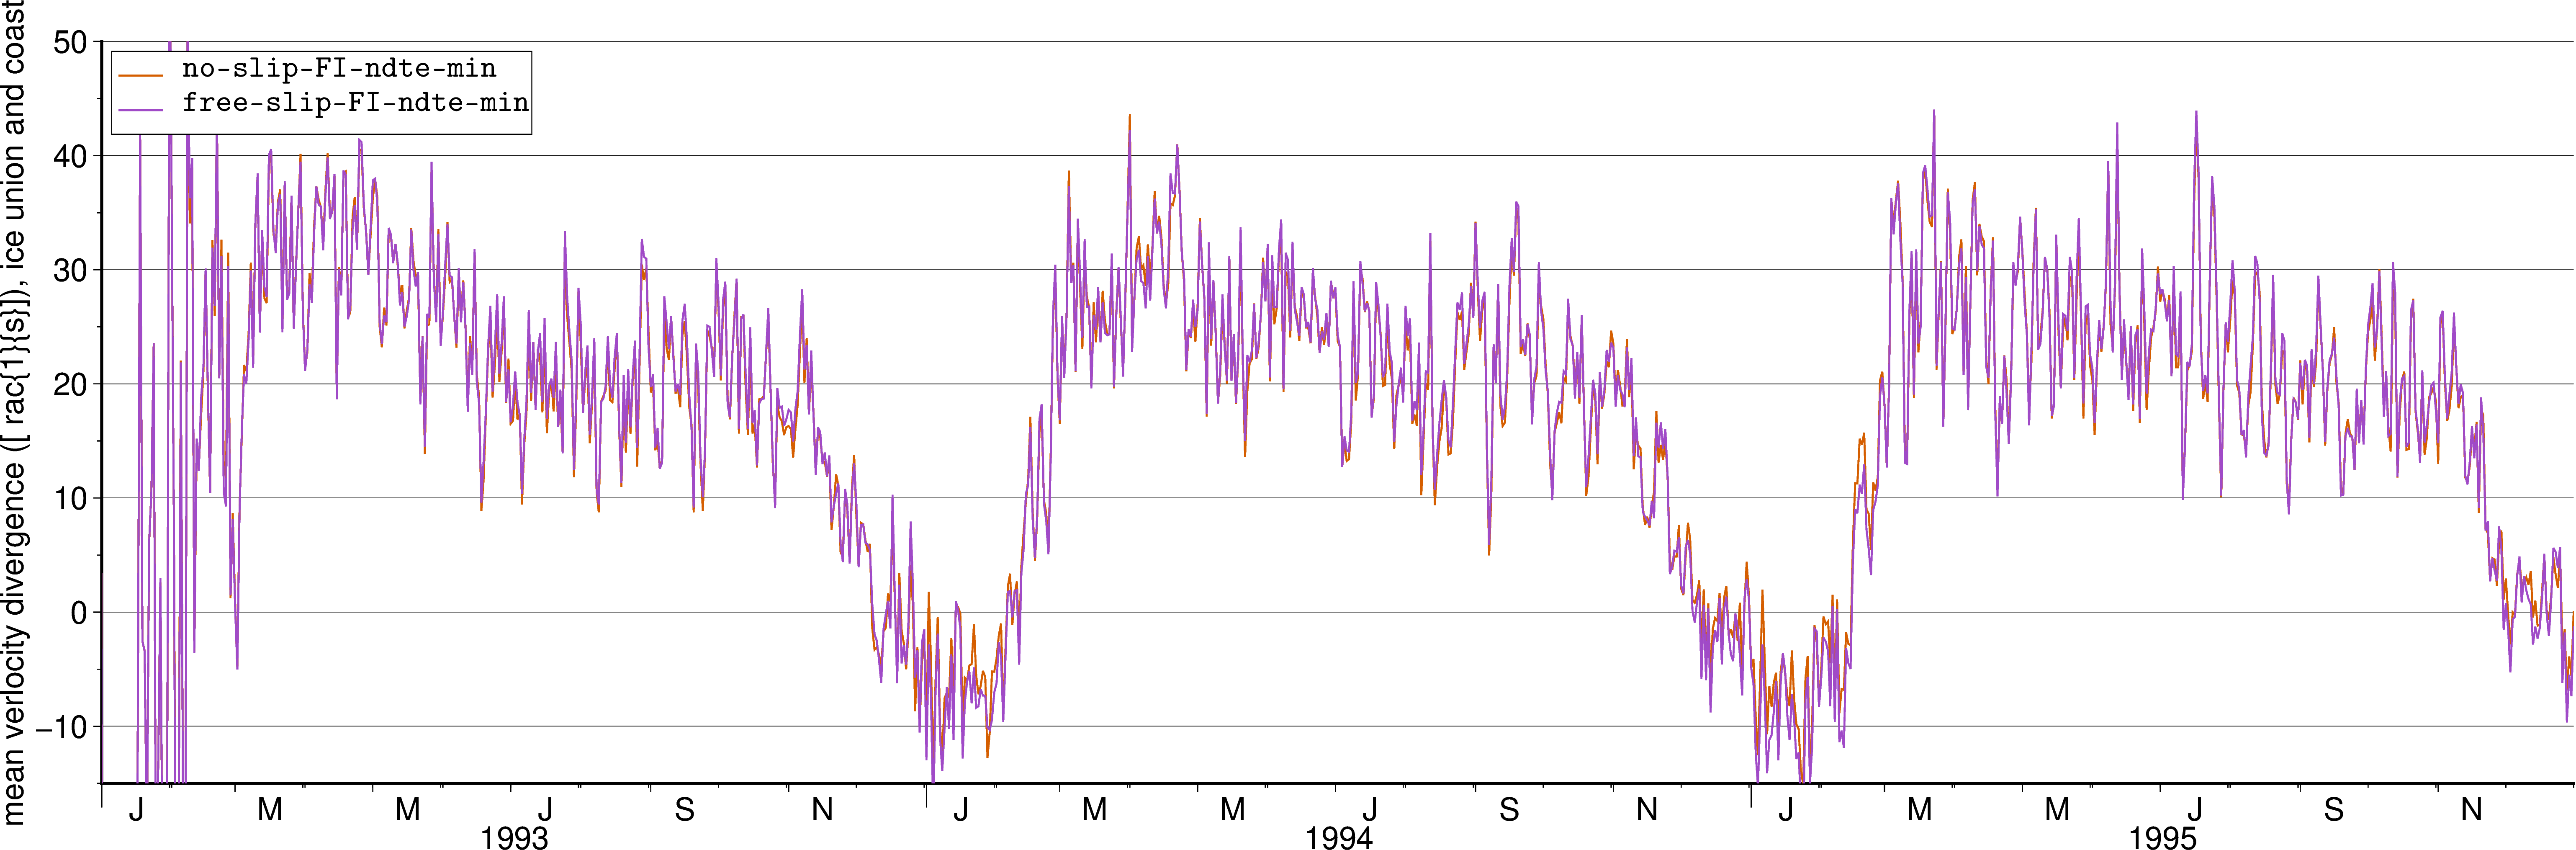

In [10]:
DIVU_cst = { sim1 :  {'divu' : divu1_cst},
            sim2 :  {'divu' : divu2_cst}}
tb1.pygmt_timeseries(DIVU_cst, 
                    comp_name   = "SH",
                    primary_key = "divu",
                    climatology = False,
                    yaxis_pri   = "a10f5g10+lmean verlocity divergence (@[\\frac{1}{s}@]), ice union and coast",
                    ylim        = [-15,50],
                    show_fig    = True, 
                    P_png       = D_out / f"DIVU_SH_union_and_cst_{sim1}_{sim2}_1993-1993.png",
                    legend_pos  = "JTL+jTL+o0.2c+w8.5c")

### shear

In [11]:
shear1    = _safe_get(ds1, "shear")
shear2    = _safe_get(ds2, "shear")
shear1_1d  = _area_weighted_mean(shear1, area, mask=ice_union)
shear2_1d  = _area_weighted_mean(shear2, area, mask=ice_union)
shear1_cst = _area_weighted_mean(shear1, area, mask=ice_union & cst_bnd)
shear2_cst = _area_weighted_mean(shear2, area, mask=ice_union & cst_bnd)

2026-01-06 14:13:18,896 - INFO - no-slip-FI-ndte-min simulation will be included in extract_min_max_dates()
2026-01-06 14:13:18,899 - INFO - free-slip-FI-ndte-min simulation will be included in extract_min_max_dates()
2026-01-06 14:13:18,995 - INFO - pulling out data array for no-slip-FI-ndte-min and putting into dataframe
2026-01-06 14:13:18,996 - INFO - legend label: @[\texttt{no-slip-FI-ndte-min}@[
2026-01-06 14:13:18,998 - INFO - line color  : #D55E00
2026-01-06 14:13:34,520 - INFO - pulling out data array for free-slip-FI-ndte-min and putting into dataframe
2026-01-06 14:13:34,522 - INFO - legend label: @[\texttt{free-slip-FI-ndte-min}@[
2026-01-06 14:13:34,523 - INFO - line color  : #A04AC7
2026-01-06 14:13:52,219 - INFO - saved figure to /home/581/da1339/AFIM_archive/_comparisons/no-slip-FI-ndte-min_VS_free-slip-FI-ndte-min/SI/SHEAR_SH_union_no-slip-FI-ndte-min_free-slip-FI-ndte-min_1993-1993.png


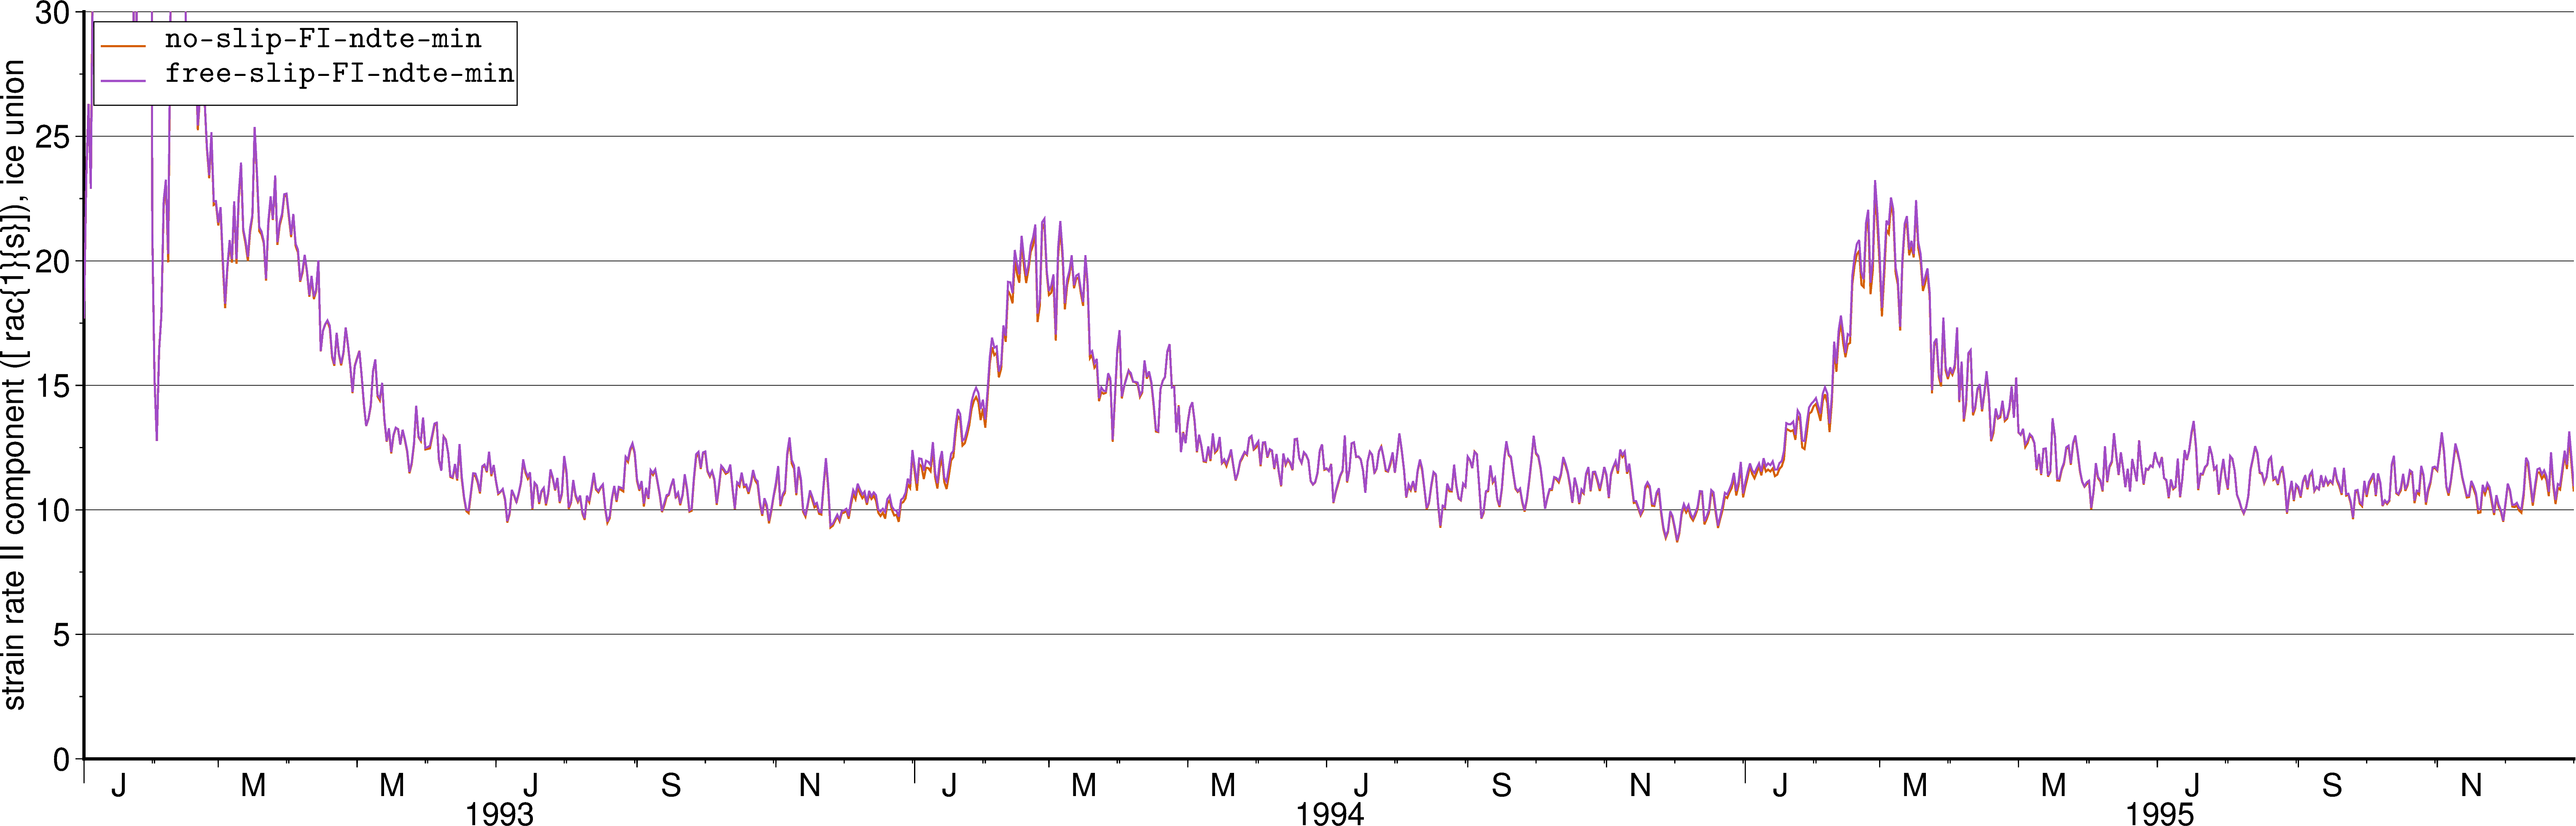

In [12]:
SHEAR_dict = {sim1 :  {'shear' : shear1_1d},
              sim2 :  {'shear' : shear2_1d}}
tb1.pygmt_timeseries(SHEAR_dict, 
                    comp_name   = "SH",
                    primary_key = "shear",
                    climatology = False,
                    yaxis_pri   = "a5f2.5g5+lstrain rate II component (@[\\frac{1}{s}@]), ice union",
                    ylim        = [0,30],
                    show_fig    = True, 
                    P_png       = D_out / f"SHEAR_SH_union_{sim1}_{sim2}_1993-1993.png",
                    legend_pos  = "JTL+jTL+o0.2c+w8.5c")

2026-01-06 14:13:53,192 - INFO - no-slip-FI-ndte-min simulation will be included in extract_min_max_dates()
2026-01-06 14:13:53,196 - INFO - free-slip-FI-ndte-min simulation will be included in extract_min_max_dates()
2026-01-06 14:13:53,263 - INFO - pulling out data array for no-slip-FI-ndte-min and putting into dataframe
2026-01-06 14:13:53,264 - INFO - legend label: @[\texttt{no-slip-FI-ndte-min}@[
2026-01-06 14:13:53,264 - INFO - line color  : #D55E00
2026-01-06 14:14:09,568 - INFO - pulling out data array for free-slip-FI-ndte-min and putting into dataframe
2026-01-06 14:14:09,571 - INFO - legend label: @[\texttt{free-slip-FI-ndte-min}@[
2026-01-06 14:14:09,572 - INFO - line color  : #A04AC7
2026-01-06 14:14:27,842 - INFO - saved figure to /home/581/da1339/AFIM_archive/_comparisons/no-slip-FI-ndte-min_VS_free-slip-FI-ndte-min/SI/SHEAR_SH_union_and_cst_no-slip-FI-ndte-min_free-slip-FI-ndte-min_1993-1993.png


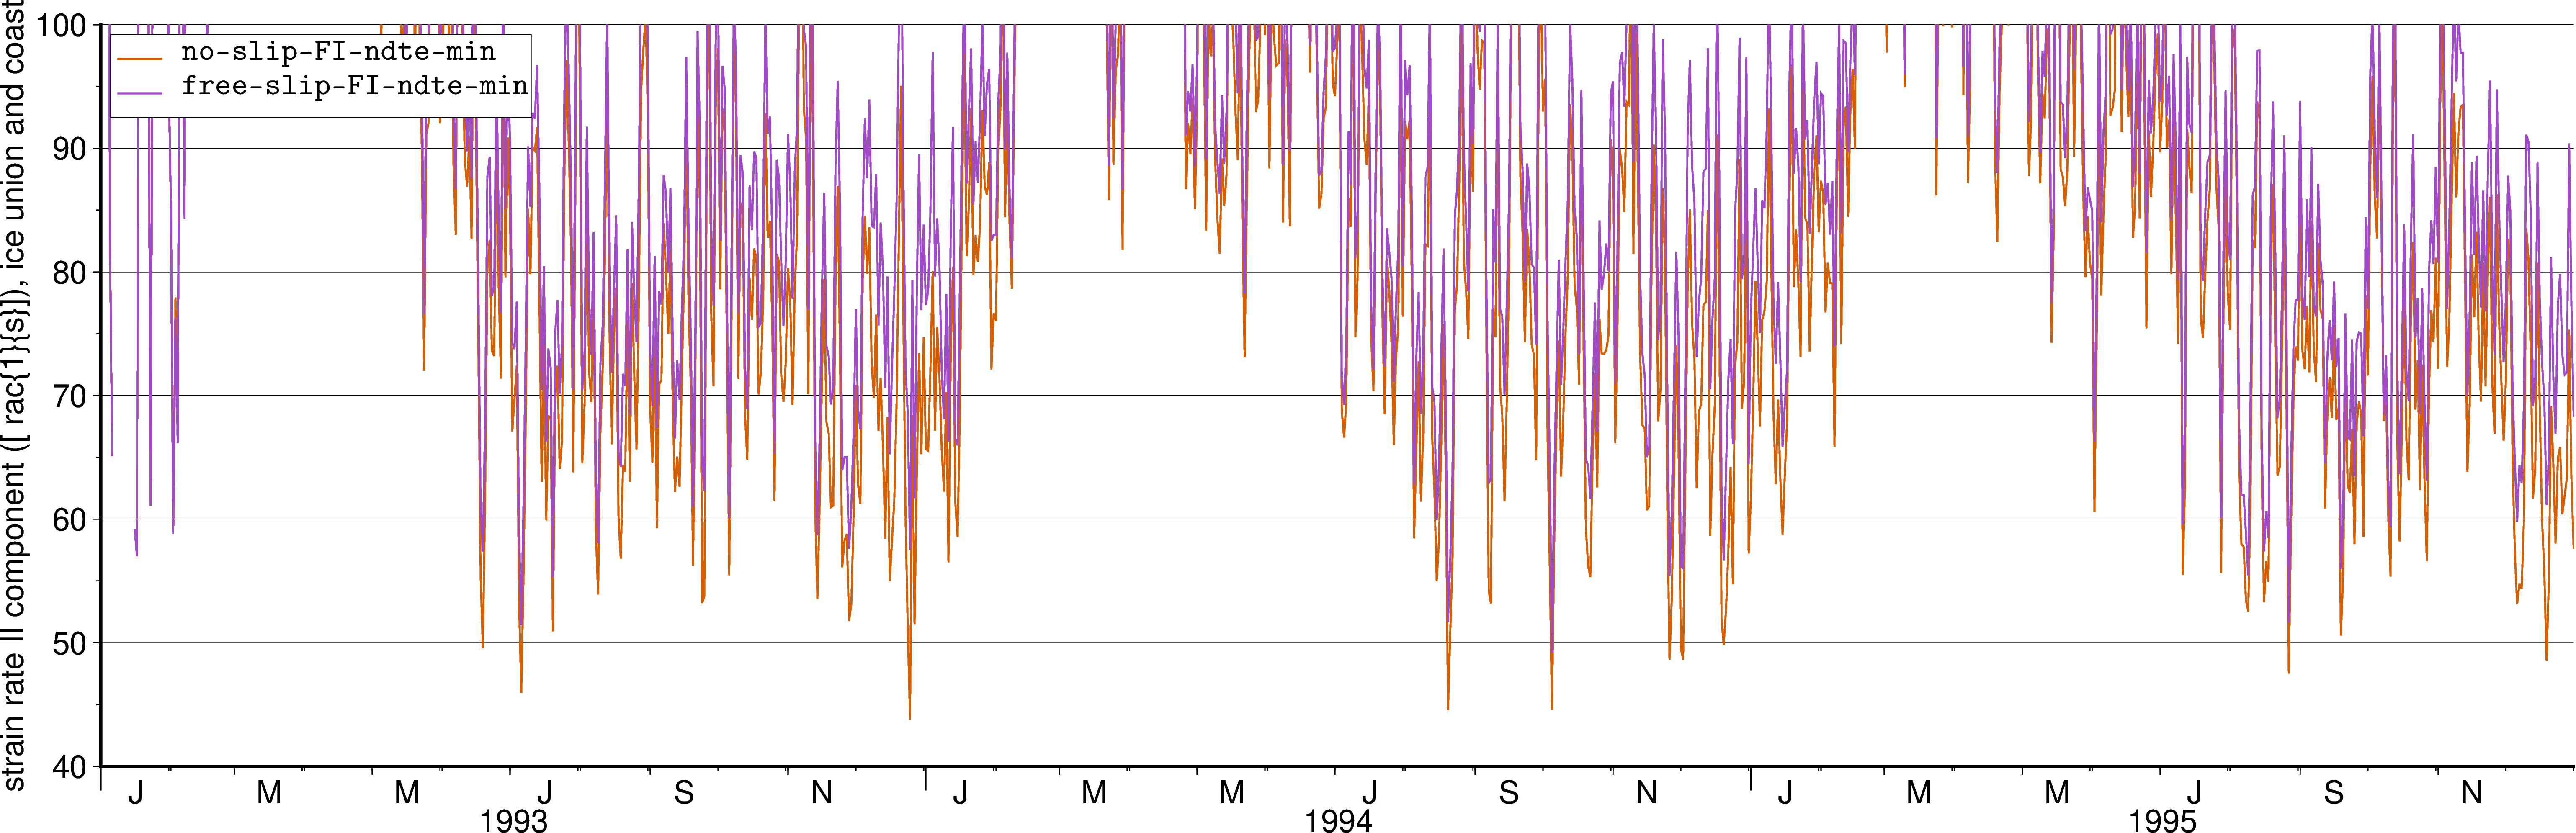

In [13]:
SHEAR_cst = { sim1 :  {'shear' : shear1_cst},
              sim2 :  {'shear' : shear2_cst}}
tb1.pygmt_timeseries(SHEAR_cst, 
                    comp_name   = "SH",
                    primary_key = "shear",
                    climatology = False,
                    yaxis_pri   = "a10f5g10+lstrain rate II component (@[\\frac{1}{s}@]), ice union and coast",
                    ylim        = [40,100],
                    show_fig    = True, 
                    P_png       = D_out / f"SHEAR_SH_union_and_cst_{sim1}_{sim2}_1993-1993.png",
                    legend_pos  = "JTL+jTL+o0.2c+w8.5c")

### sigP

In [14]:
sigP1    = _safe_get(ds1, "sigP")
sigP2    = _safe_get(ds2, "sigP")
sigP1_1d  = _area_weighted_mean(sigP1, area, mask=ice_union)
sigP2_1d  = _area_weighted_mean(sigP2, area, mask=ice_union)
sigP1_cst = _area_weighted_mean(sigP1, area, mask=ice_union & cst_bnd)
sigP2_cst = _area_weighted_mean(sigP2, area, mask=ice_union & cst_bnd)
print(sigP1_1d.max().values)
print(sigP1_1d.min().values)
print(sigP1_1d.mean().values)
print(sigP1_cst.max().values)
print(sigP1_cst.min().values)
print(sigP1_cst.mean().values)

/g/data/gv90/da1339/conda/envs/AFIM/lib/python3.13/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


1924.0284


/g/data/gv90/da1339/conda/envs/AFIM/lib/python3.13/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


1.4628509e-07


/g/data/gv90/da1339/conda/envs/AFIM/lib/python3.13/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


748.0744


/g/data/gv90/da1339/conda/envs/AFIM/lib/python3.13/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


4044.186


/g/data/gv90/da1339/conda/envs/AFIM/lib/python3.13/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


1.4628509e-07


/g/data/gv90/da1339/conda/envs/AFIM/lib/python3.13/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


1741.3876


2026-01-06 14:16:05,276 - INFO - no-slip-FI-ndte-min simulation will be included in extract_min_max_dates()
2026-01-06 14:16:05,280 - INFO - free-slip-FI-ndte-min simulation will be included in extract_min_max_dates()
2026-01-06 14:16:05,372 - INFO - pulling out data array for no-slip-FI-ndte-min and putting into dataframe
2026-01-06 14:16:05,373 - INFO - legend label: @[\texttt{no-slip-FI-ndte-min}@[
2026-01-06 14:16:05,374 - INFO - line color  : #D55E00
2026-01-06 14:16:20,179 - INFO - pulling out data array for free-slip-FI-ndte-min and putting into dataframe
2026-01-06 14:16:20,182 - INFO - legend label: @[\texttt{free-slip-FI-ndte-min}@[
2026-01-06 14:16:20,183 - INFO - line color  : #A04AC7
2026-01-06 14:16:37,523 - INFO - saved figure to /home/581/da1339/AFIM_archive/_comparisons/no-slip-FI-ndte-min_VS_free-slip-FI-ndte-min/SI/SIGP_SH_union_no-slip-FI-ndte-min_free-slip-FI-ndte-min_1993-1993.png


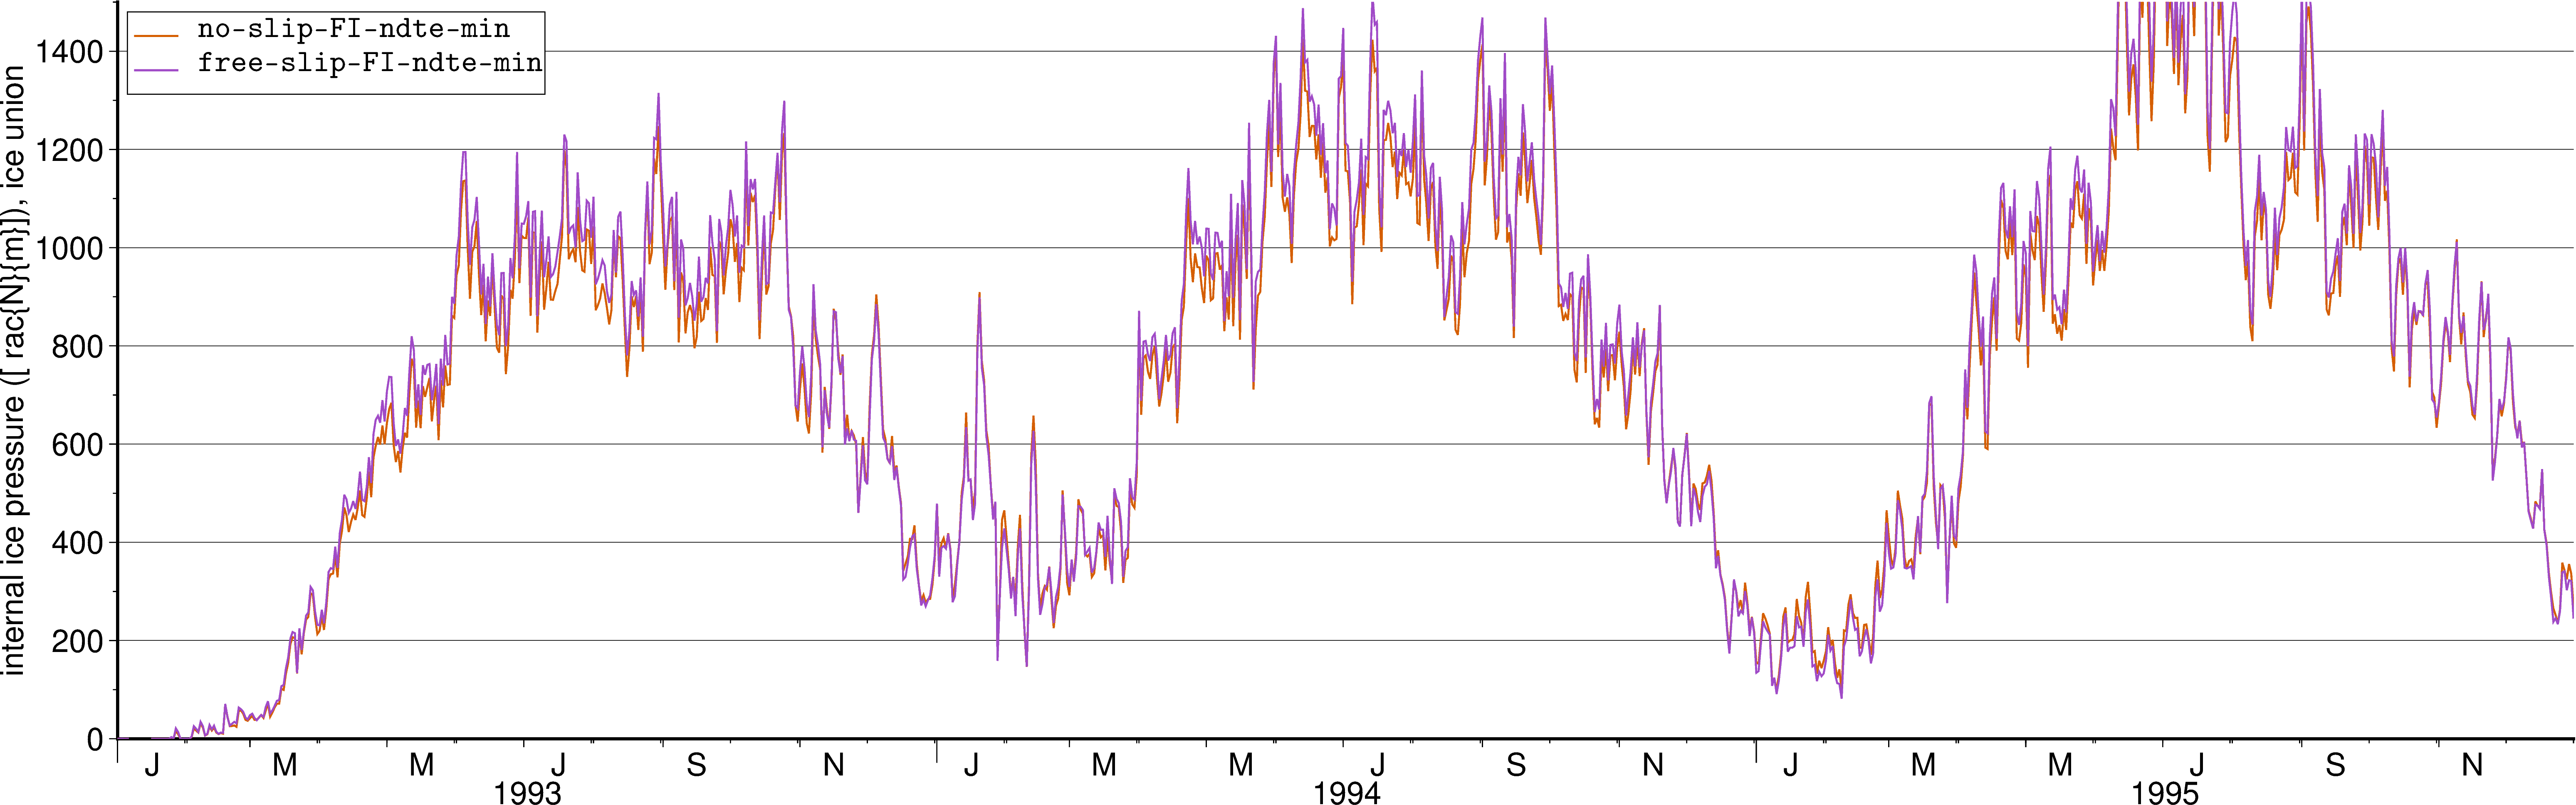

In [15]:
SIGP_dict = {sim1 :  {'sigP' : sigP1_1d},
             sim2 :  {'sigP' : sigP2_1d}}
tb1.pygmt_timeseries(SIGP_dict, 
                    comp_name   = "SH",
                    primary_key = "sigP",
                    climatology = False,
                    yaxis_pri   = "a200f100g200+linternal ice pressure (@[\\frac{N}{m}@]), ice union",
                    ylim        = [0,1500],
                    show_fig    = True, 
                    P_png       = D_out / f"SIGP_SH_union_{sim1}_{sim2}_1993-1993.png",
                    legend_pos  = "JTL+jTL+o0.2c+w8.5c")

2026-01-06 14:16:38,424 - INFO - no-slip-FI-ndte-min simulation will be included in extract_min_max_dates()
2026-01-06 14:16:38,428 - INFO - free-slip-FI-ndte-min simulation will be included in extract_min_max_dates()
2026-01-06 14:16:38,501 - INFO - pulling out data array for no-slip-FI-ndte-min and putting into dataframe
2026-01-06 14:16:38,502 - INFO - legend label: @[\texttt{no-slip-FI-ndte-min}@[
2026-01-06 14:16:38,503 - INFO - line color  : #D55E00
/g/data/gv90/da1339/conda/envs/AFIM/lib/python3.13/site-packages/dask/_task_spec.py:764: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
2026-01-06 14:16:55,154 - INFO - pulling out data array for free-slip-FI-ndte-min and putting into dataframe
2026-01-06 14:16:55,156 - INFO - legend label: @[\texttt{free-slip-FI-ndte-min}@[
2026-01-06 14:16:55,157 - INFO - line color  : #A04AC7
2026-01-06 14:17:13,303 - INFO - saved figure to /home/581/da1339/AFIM_archive/_comparisons/no-slip-FI-ndte-min_VS_free-

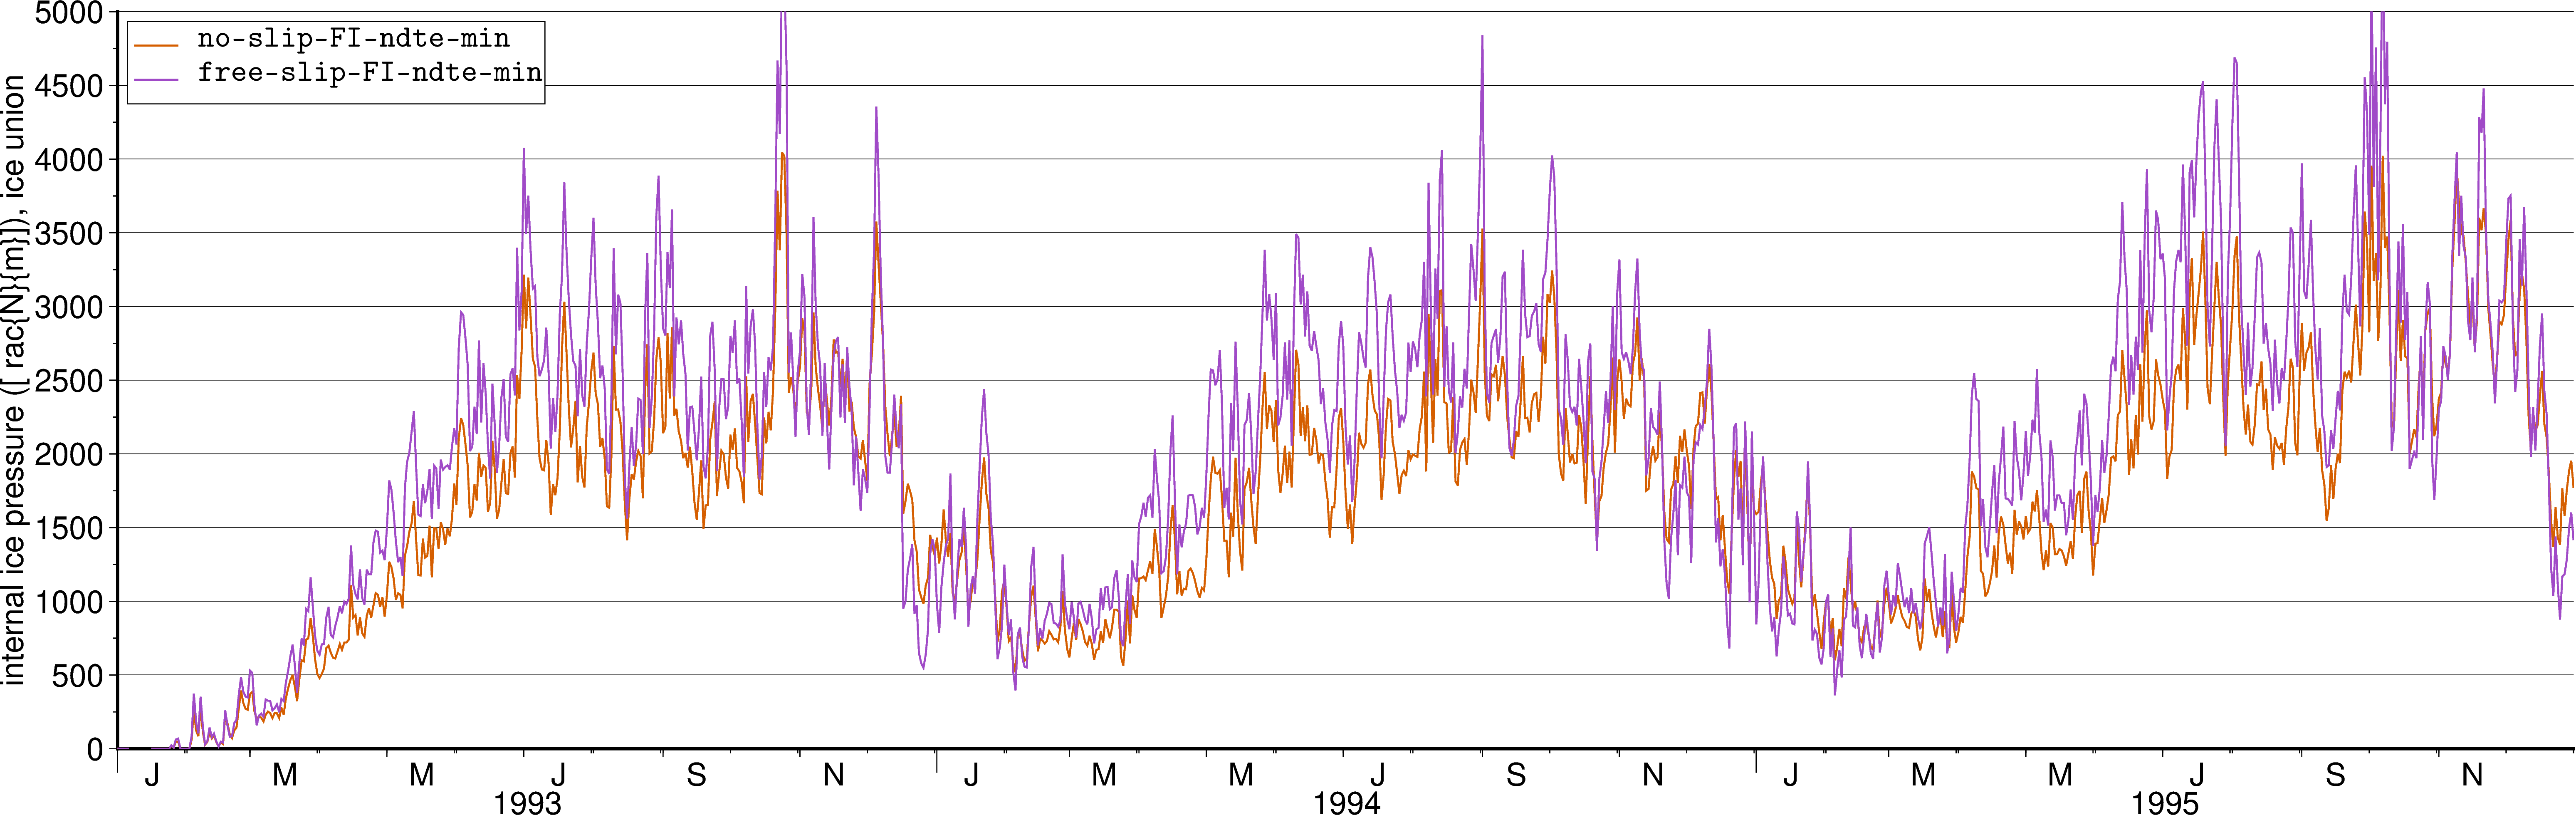

In [16]:
SIGP_cst = {sim1 :  {'sigP' : sigP1_cst},
            sim2 :  {'sigP' : sigP2_cst}}
tb1.pygmt_timeseries(SIGP_cst, 
                    comp_name   = "SH",
                    primary_key = "sigP",
                    climatology = False,
                    yaxis_pri   = "a500f250g500+linternal ice pressure (@[\\frac{N}{m}@]), ice union",
                    ylim        = [0,5000],
                    show_fig    = True, 
                    P_png       = D_out / f"SIGP_SH_union_and_cst_{sim1}_{sim2}_1993-1993.png",
                    legend_pos  = "JTL+jTL+o0.2c+w8.5c")

### daidtt & daidtd

In [17]:
# Tendencies integrated over ice (useful for "started from zero ice" experiments)
daidtd1_1d = (ds1['daidtd'].where(ice_union) * area).sum(_guess_spatial_dims(area), skipna=True) / tb1.SIC_scale
daidtt1_1d = (ds1['daidtt'].where(ice_union) * area).sum(_guess_spatial_dims(area), skipna=True) / tb1.SIC_scale
daidtd2_1d = (ds2['daidtd'].where(ice_union) * area).sum(_guess_spatial_dims(area), skipna=True) / tb1.SIC_scale
daidtt2_1d = (ds2['daidtt'].where(ice_union) * area).sum(_guess_spatial_dims(area), skipna=True) / tb1.SIC_scale
daidtd1_cst = (ds1['daidtd'].where(ice_union & cst_bnd) * area).sum(_guess_spatial_dims(area), skipna=True) / tb1.SIC_scale
daidtt1_cst = (ds1['daidtt'].where(ice_union & cst_bnd) * area).sum(_guess_spatial_dims(area), skipna=True) / tb1.SIC_scale
daidtd2_cst = (ds2['daidtd'].where(ice_union & cst_bnd) * area).sum(_guess_spatial_dims(area), skipna=True) / tb1.SIC_scale
daidtt2_cst = (ds2['daidtt'].where(ice_union & cst_bnd) * area).sum(_guess_spatial_dims(area), skipna=True) / tb1.SIC_scale
print(sim1)
print(daidtd1_cst.max().values)
print(daidtd1_cst.min().values)
print(daidtd1_cst.mean().values)
print(daidtt1_cst.max().values)
print(daidtt1_cst.min().values)
print(daidtt1_cst.mean().values)
print(sim2)
print(daidtd2_cst.max().values)
print(daidtd2_cst.min().values)
print(daidtd2_cst.mean().values)
print(daidtt2_cst.max().values)
print(daidtt2_cst.min().values)
print(daidtt2_cst.mean().values)
print(daidtt2_cst.max().values)

no-slip-FI-ndte-min
0.1919966
-8.30626
-2.958721
8.1251
-0.17321633
2.9633932
free-slip-FI-ndte-min
0.22970553
-8.894723
-3.1471531
8.663725
-0.2021943
3.1495368
8.663725


2026-01-06 14:20:28,301 - INFO - no-slip-FI-ndte-min simulation will be included in extract_min_max_dates()
2026-01-06 14:20:28,307 - INFO - free-slip-FI-ndte-min simulation will be included in extract_min_max_dates()
2026-01-06 14:20:28,388 - INFO - pulling out data array for no-slip-FI-ndte-min and putting into dataframe
2026-01-06 14:20:28,389 - INFO - legend label: @[\texttt{no-slip-FI-ndte-min}@[
2026-01-06 14:20:28,391 - INFO - line color  : #D55E00
2026-01-06 14:20:41,490 - INFO - pulling out data array for free-slip-FI-ndte-min and putting into dataframe
2026-01-06 14:20:41,492 - INFO - legend label: @[\texttt{free-slip-FI-ndte-min}@[
2026-01-06 14:20:41,492 - INFO - line color  : #A04AC7
2026-01-06 14:20:55,981 - INFO - saved figure to /home/581/da1339/AFIM_archive/_comparisons/no-slip-FI-ndte-min_VS_free-slip-FI-ndte-min/SI/DAIDTD_SH_union_no-slip-FI-ndte-min_free-slip-FI-ndte-min_1993-1993.png


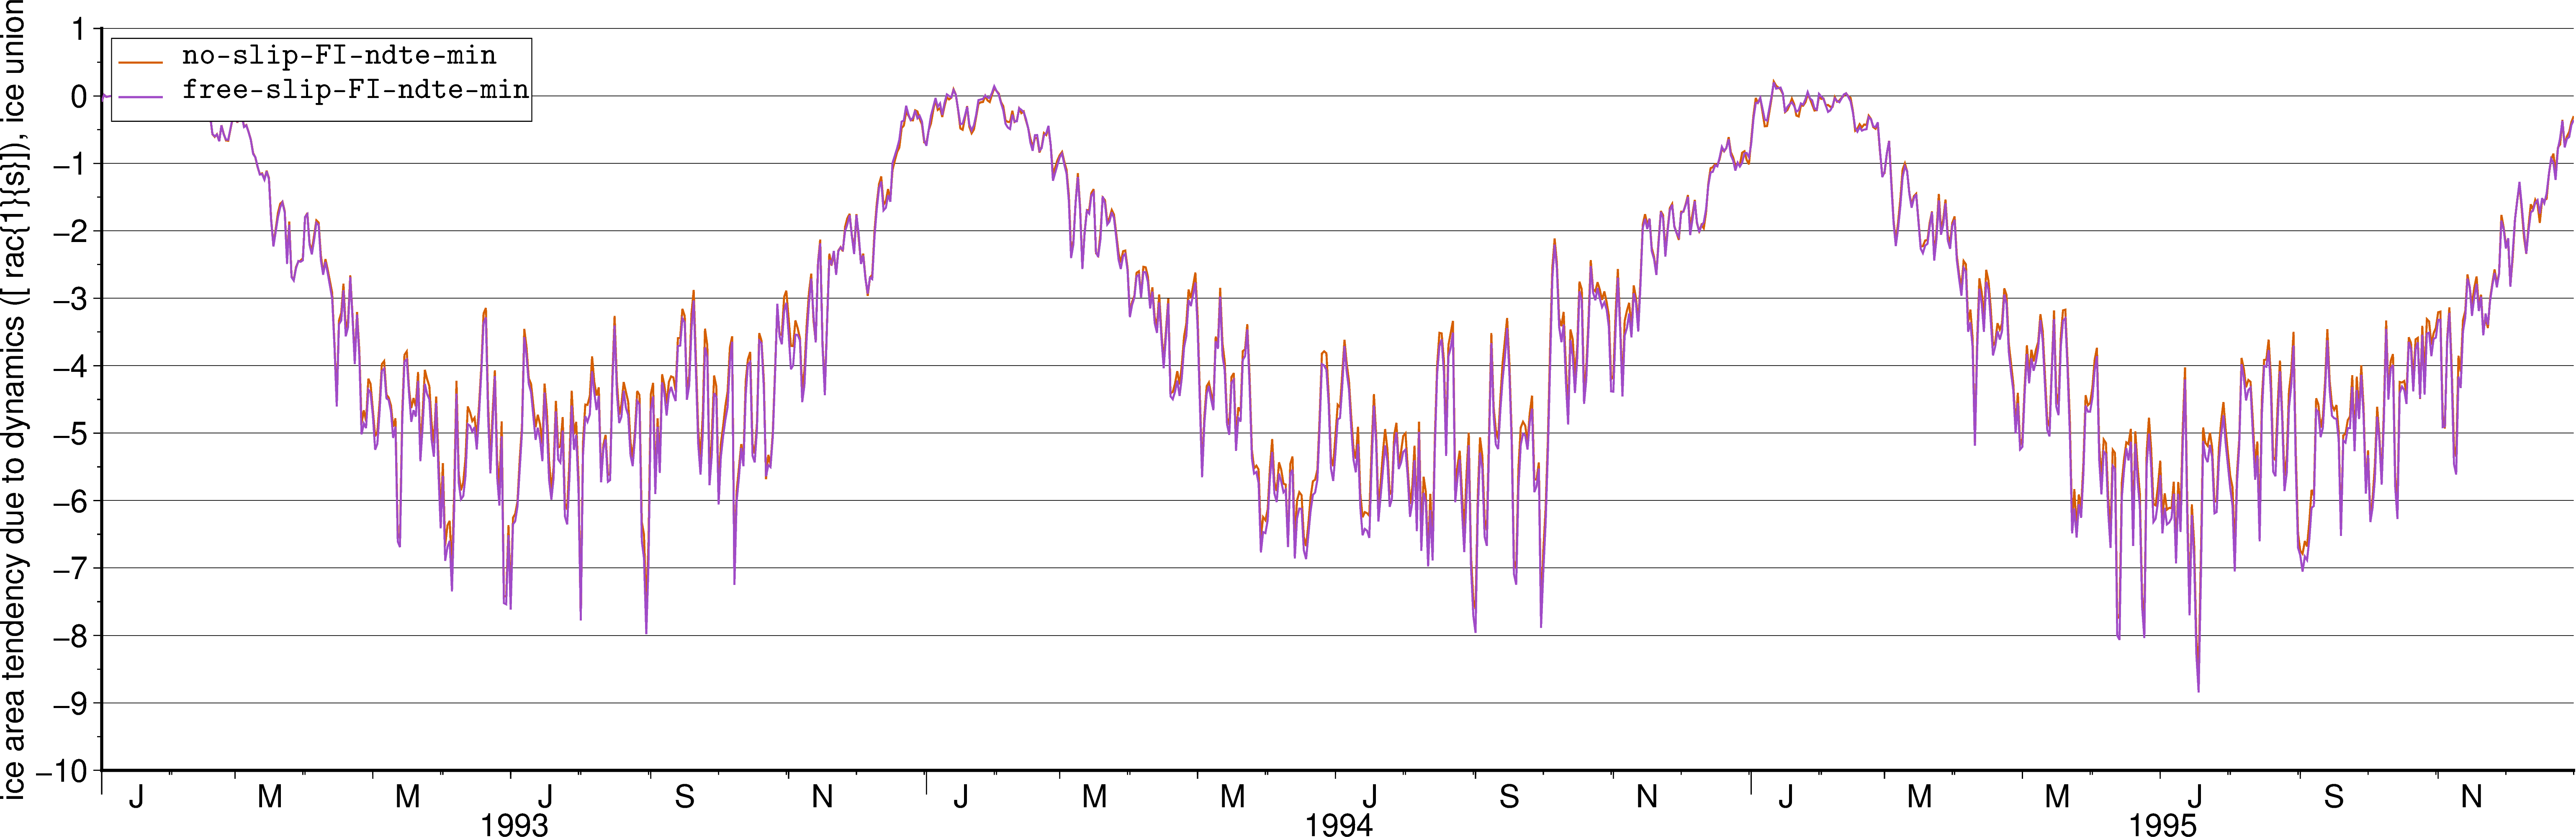

In [18]:
DAIDTD_dict = {sim1 :  {'daidtd' : daidtd1_1d},
               sim2 :  {'daidtd' : daidtd2_1d}}
tb1.pygmt_timeseries(DAIDTD_dict, 
                    comp_name   = "SH",
                    primary_key = "daidtd",
                    climatology = False,
                    yaxis_pri   = "a1f.5g1+lice area tendency due to dynamics (@[\\frac{1}{s}@]), ice union",
                    ylim        = [-10,1],
                    show_fig    = True, 
                    P_png       = D_out / f"DAIDTD_SH_union_{sim1}_{sim2}_1993-1993.png",
                    legend_pos  = "JTL+jTL+o0.2c+w8.5c")

In [19]:
DAIDTD_cst = {sim1 :  {'daidtd' : daidtd1_cst},
              sim2 :  {'daidtd' : daidtd2_cst}}
tb1.pygmt_timeseries(DAIDTD_cst, 
                    comp_name   = "SH",
                    primary_key = "daidtd",
                    climatology = False,
                    yaxis_pri   = "a1f.5g1+lice area tendency due to dynamics (@[\\frac{1}{s}@]), ice union and coast",
                    ylim        = [-10,1],
                    show_fig    = True, 
                    P_png       = D_out / f"DAIDTD_SH_union_and_cst_{sim1}_{sim2}_1993-1993.png",
                    legend_pos  = "JTL+jTL+o0.2c+w8.5c")

2026-01-06 14:20:56,941 - INFO - no-slip-FI-ndte-min simulation will be included in extract_min_max_dates()
2026-01-06 14:20:56,944 - INFO - free-slip-FI-ndte-min simulation will be included in extract_min_max_dates()
2026-01-06 14:20:57,014 - INFO - pulling out data array for no-slip-FI-ndte-min and putting into dataframe
2026-01-06 14:20:57,015 - INFO - legend label: @[\texttt{no-slip-FI-ndte-min}@[
2026-01-06 14:20:57,016 - INFO - line color  : #D55E00
2026-01-06 14:21:11,382 - INFO - pulling out data array for free-slip-FI-ndte-min and putting into dataframe
2026-01-06 14:21:11,384 - INFO - legend label: @[\texttt{free-slip-FI-ndte-min}@[
2026-01-06 14:21:11,385 - INFO - line color  : #A04AC7
2026-01-06 14:21:27,485 - INFO - saved figure to /home/581/da1339/AFIM_archive/_comparisons/no-slip-FI-ndte-min_VS_free-slip-FI-ndte-min/SI/DAIDTD_SH_union_and_cst_no-slip-FI-ndte-min_free-slip-FI-ndte-min_1993-1993.png


In [20]:
DAIDTT_dict = {sim1 :  {'daidtt' : daidtt1_1d},
               sim2 :  {'daidtt' : daidtt2_1d}}
tb1.pygmt_timeseries(DAIDTT_dict, 
                    comp_name   = "SH",
                    primary_key = "daidtt",
                    climatology = False,
                    yaxis_pri   = "a1f.5g1+lice area tendency due to THERMOdynamics (@[\\frac{1}{s}@]), ice union",
                    ylim        = [-2,20],
                    show_fig    = True, 
                    P_png       = D_out / f"DAIDTT_SH_union_{sim1}_{sim2}_1993-1993.png",
                    legend_pos  = "JTL+jTL+o0.2c+w8.5c")

2026-01-06 14:21:28,463 - INFO - no-slip-FI-ndte-min simulation will be included in extract_min_max_dates()
2026-01-06 14:21:28,467 - INFO - free-slip-FI-ndte-min simulation will be included in extract_min_max_dates()
2026-01-06 14:21:28,540 - INFO - pulling out data array for no-slip-FI-ndte-min and putting into dataframe
2026-01-06 14:21:28,541 - INFO - legend label: @[\texttt{no-slip-FI-ndte-min}@[
2026-01-06 14:21:28,542 - INFO - line color  : #D55E00
2026-01-06 14:21:42,033 - INFO - pulling out data array for free-slip-FI-ndte-min and putting into dataframe
2026-01-06 14:21:42,036 - INFO - legend label: @[\texttt{free-slip-FI-ndte-min}@[
2026-01-06 14:21:42,037 - INFO - line color  : #A04AC7
2026-01-06 14:21:56,749 - INFO - saved figure to /home/581/da1339/AFIM_archive/_comparisons/no-slip-FI-ndte-min_VS_free-slip-FI-ndte-min/SI/DAIDTT_SH_union_no-slip-FI-ndte-min_free-slip-FI-ndte-min_1993-1993.png


In [21]:
DAIDTT_cst = {sim1 :  {'daidtt' : daidtt1_cst},
              sim2 :  {'daidtt' : daidtt2_cst}}
tb1.pygmt_timeseries(DAIDTT_cst, 
                    comp_name   = "SH",
                    primary_key = "daidtt",
                    climatology = False,
                    yaxis_pri   = "a1f.5g1+lice area tendency due to THERMOdynamics (@[\\frac{1}{s}@]), ice union and coast",
                    ylim        = [0,10],
                    show_fig    = True, 
                    P_png       = D_out / f"DAIDTT_SH_union_and_cst_{sim1}_{sim2}_1993-1993.png",
                    legend_pos  = "JTL+jTL+o0.2c+w8.5c")

2026-01-06 14:21:57,870 - INFO - no-slip-FI-ndte-min simulation will be included in extract_min_max_dates()
2026-01-06 14:21:57,873 - INFO - free-slip-FI-ndte-min simulation will be included in extract_min_max_dates()
2026-01-06 14:21:57,952 - INFO - pulling out data array for no-slip-FI-ndte-min and putting into dataframe
2026-01-06 14:21:57,953 - INFO - legend label: @[\texttt{no-slip-FI-ndte-min}@[
2026-01-06 14:21:57,955 - INFO - line color  : #D55E00
2026-01-06 14:22:12,378 - INFO - pulling out data array for free-slip-FI-ndte-min and putting into dataframe
2026-01-06 14:22:12,381 - INFO - legend label: @[\texttt{free-slip-FI-ndte-min}@[
2026-01-06 14:22:12,382 - INFO - line color  : #A04AC7
2026-01-06 14:22:28,568 - INFO - saved figure to /home/581/da1339/AFIM_archive/_comparisons/no-slip-FI-ndte-min_VS_free-slip-FI-ndte-min/SI/DAIDTT_SH_union_and_cst_no-slip-FI-ndte-min_free-slip-FI-ndte-min_1993-1993.png


## spatial differences

### aice

In [48]:
Amean = (ds2["aice"] - ds1["aice"]).mean("time").load()
tb1.pygmt_map_plot_one_var(
    Amean,
    var_name="aice",                      # IMPORTANT: no "diff" substring
    sim_name=f"{sim2}_minus_{sim1}",
    plot_regions=8,
    plot_bathymetry=False,
    tit_str=f"Annual mean difference ({sim2} − {sim1})",
    cmap="polar",                          # diverging
    series=[-.1,.1],
    reverse=False,                         # pass explicitly to avoid plot_var_dict lookup
    cbar_label="ice concentration difference",
    cbar_units="1",
    diff_plot=False,                       # keep False for continuous diffs
    use_tcoords=True,                      # required by prepare_data_for_pygmt_plot()
    overwrite_fig=True,
    show_fig=True,
)

KeyError: "No variable named 'aice'. Variables on the dataset include ['tmask', 'uvel', 'vvel', 'uvelE', 'vvelN', ..., 'ELAT', 'TLAT', 'ULAT', 'ULON', 'NLAT']"

### ice speed

In [ ]:
date_str = "1993-09-15"
cst_gc_wdth = 10
stride_days = 1  # set to 2, 5, 7 for fewer frames if desired

# Load minimal vars (adjust if you use different names)
vars_req = ["tmask", "uvel", "vvel", "uvelE", "vvelN", "uvelN", "vvelE"]

ds1 = tb1.load_cice_zarr(variables=vars_req, slice_hem=True)
ds2 = tb2.load_cice_zarr(variables=vars_req, slice_hem=True)

# Align time
ds1, ds2 = xr.align(ds1, ds2, join="inner")
msk1, msk2 = xr.align(msk1, msk2, join="inner")  # SI_mask or FI_mask etc

2026-01-07 16:19:31,573 - INFO - Loading Zarr groups between 1993-01-01 and 1995-12-31
2026-01-07 16:19:40,514 - INFO -   slicing hemisphere
2026-01-07 16:19:41,077 - INFO - Loading Zarr groups between 1993-01-01 and 1995-12-31
2026-01-07 16:19:50,016 - INFO -   slicing hemisphere


NameError: name '_coastal_band_from_tmask' is not defined

In [6]:
# Masks
ice_union = (msk1 > 0) | (msk2 > 0)
cst_bnd   = _coastal_band_from_tmask(ds1["tmask"], band=cst_gc_wdth)
cst_union = ice_union & cst_bnd  # broadcasts 2D cst_bnd across time

# Speed (lazy)
u1, v1 = _pick_collocated_uv(ds1)
u2, v2 = _pick_collocated_uv(ds2)

ispd1 = xr.apply_ufunc(np.hypot, u1, v1, dask="parallelized", output_dtypes=[np.float32])
ispd2 = xr.apply_ufunc(np.hypot, u2, v2, dask="parallelized", output_dtypes=[np.float32])

ispd_delta = (ispd2 - ispd1).where(cst_union)  # mask before loading any 2D slices

In [ ]:

du = (ds2["uvelE"] - ds1["uvelE"]).where(cst_union).sel(time=date_str)
m1 = float(ds1["uvelE"].where(cst_union).sel(time=date_str).mean().compute())
m2 = float(ds2["uvelE"].where(cst_union).sel(time=date_str).mean().compute())
md = float(du.mean().compute())
print(f"mean uvelE {sim1}: {m1}")
print(f"mean uvelE {sim2}: {m2}")
print(f"mean du ({sim2}-{sim1}): {md}; check: {m2-m1}")
dv = (ds2["vvelN"] - ds1["uvelN"]).where(cst_union).sel(time=date_str)
m1 = float(ds1["vvelN"].where(cst_union).sel(time=date_str).mean().compute())
m2 = float(ds2["vvelN"].where(cst_union).sel(time=date_str).mean().compute())
md = float(dv.mean().compute())
print(f"mean vvelN {sim1}: {m1}")
print(f"mean vvelN {sim2}: {m2}")
print(f"mean dv ({sim2}-{sim1}): {md}; check: {m2-m1}")

mean uvelE no-slip-FI-ndte-min: -0.05520506203174591
mean uvelE free-slip-FI-ndte-min: -0.05629778653383255
mean du (free-slip-FI-ndte-min-no-slip-FI-ndte-min): -0.0010927236871793866; check: -0.0010927245020866394
mean vvelN no-slip-FI-ndte-min: 0.04260879382491112
mean vvelN free-slip-FI-ndte-min: 0.045231688767671585
mean dv (free-slip-FI-ndte-min-no-slip-FI-ndte-min): 0.10168392211198807; check: 0.0026228949427604675


2026-01-07 16:52:55,930 - INFO - precomputing plot point clouds (once per panel) ...
2026-01-07 16:52:56,173 - INFO - preparing the data for plotting
2026-01-07 16:52:56,175 - INFO -    using T-grid coordinates
2026-01-07 16:52:57,563 - INFO - preparing the data for plotting
2026-01-07 16:52:57,564 - INFO -    using T-grid coordinates
2026-01-07 16:52:58,853 - INFO - preparing the data for plotting
2026-01-07 16:52:58,855 - INFO -    using T-grid coordinates
2026-01-07 16:53:05,911 - INFO - Saved figure to /g/data/gv90/da1339/GRAPHICAL/AFIM/no-slip-FI-ndte-min/DML/uvelE/1993-01-01_no-slip-FI-ndte-min_DML_uvelE.png


2026-01-07 16:53:13,724 - INFO - Saved figure to /g/data/gv90/da1339/GRAPHICAL/AFIM/no-slip-FI-ndte-min/WIO/uvelE/1993-01-01_no-slip-FI-ndte-min_WIO_uvelE.png


2026-01-07 16:53:20,514 - INFO - Saved figure to /g/data/gv90/da1339/GRAPHICAL/AFIM/no-slip-FI-ndte-min/EIO/uvelE/1993-01-01_no-slip-FI-ndte-min_EIO_uvelE.png


2026-01-07 16:53:27,652 - INFO - Saved figure to /g/data/gv90/da1339/GRAPHICAL/AFIM/no-slip-FI-ndte-min/Aus/uvelE/1993-01-01_no-slip-FI-ndte-min_Aus_uvelE.png


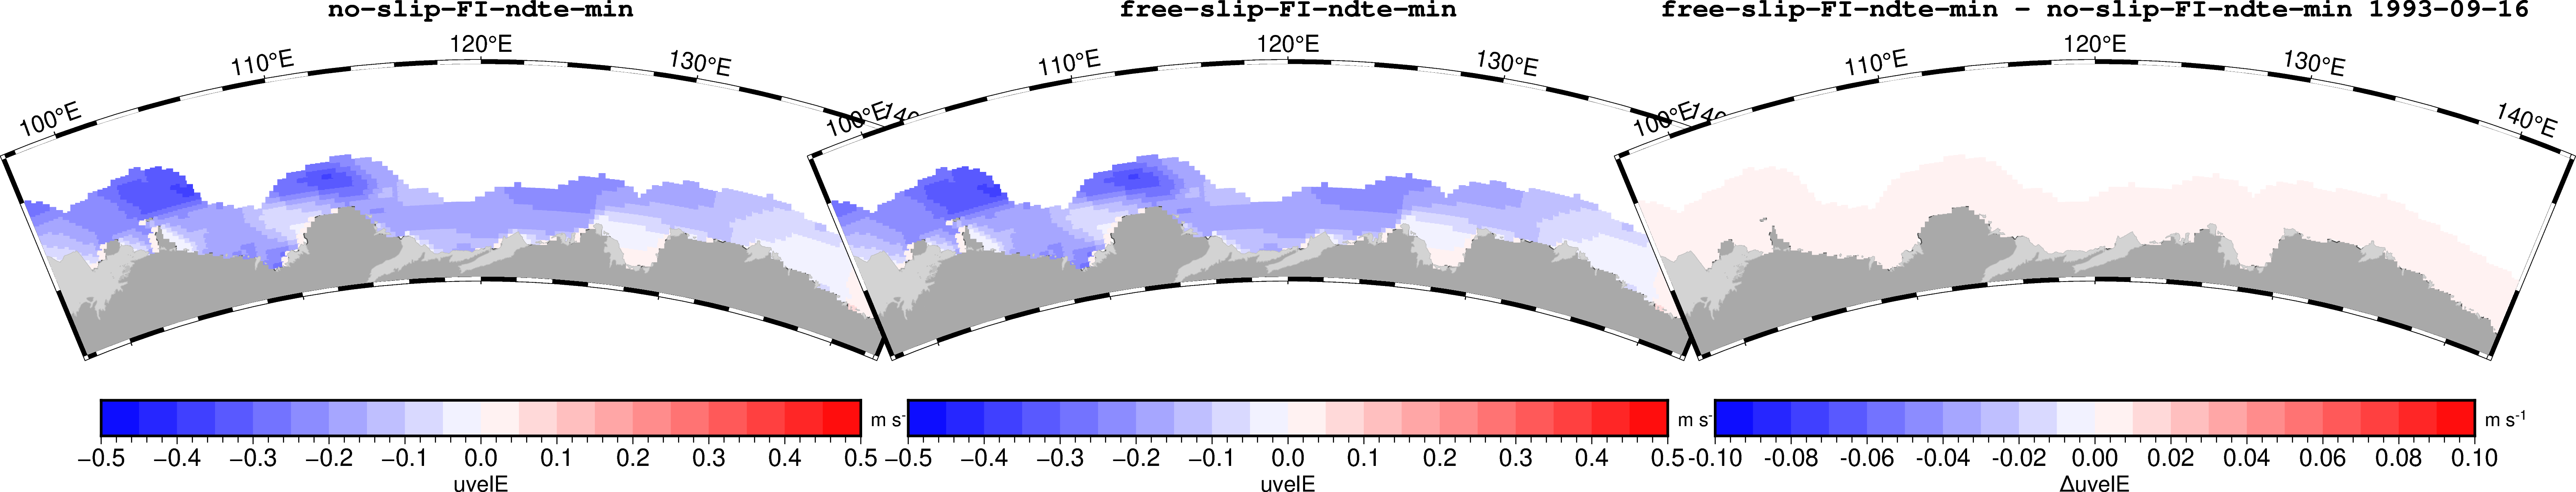

2026-01-07 16:53:35,244 - INFO - Saved figure to /g/data/gv90/da1339/GRAPHICAL/AFIM/no-slip-FI-ndte-min/VOL/uvelE/1993-01-01_no-slip-FI-ndte-min_VOL_uvelE.png


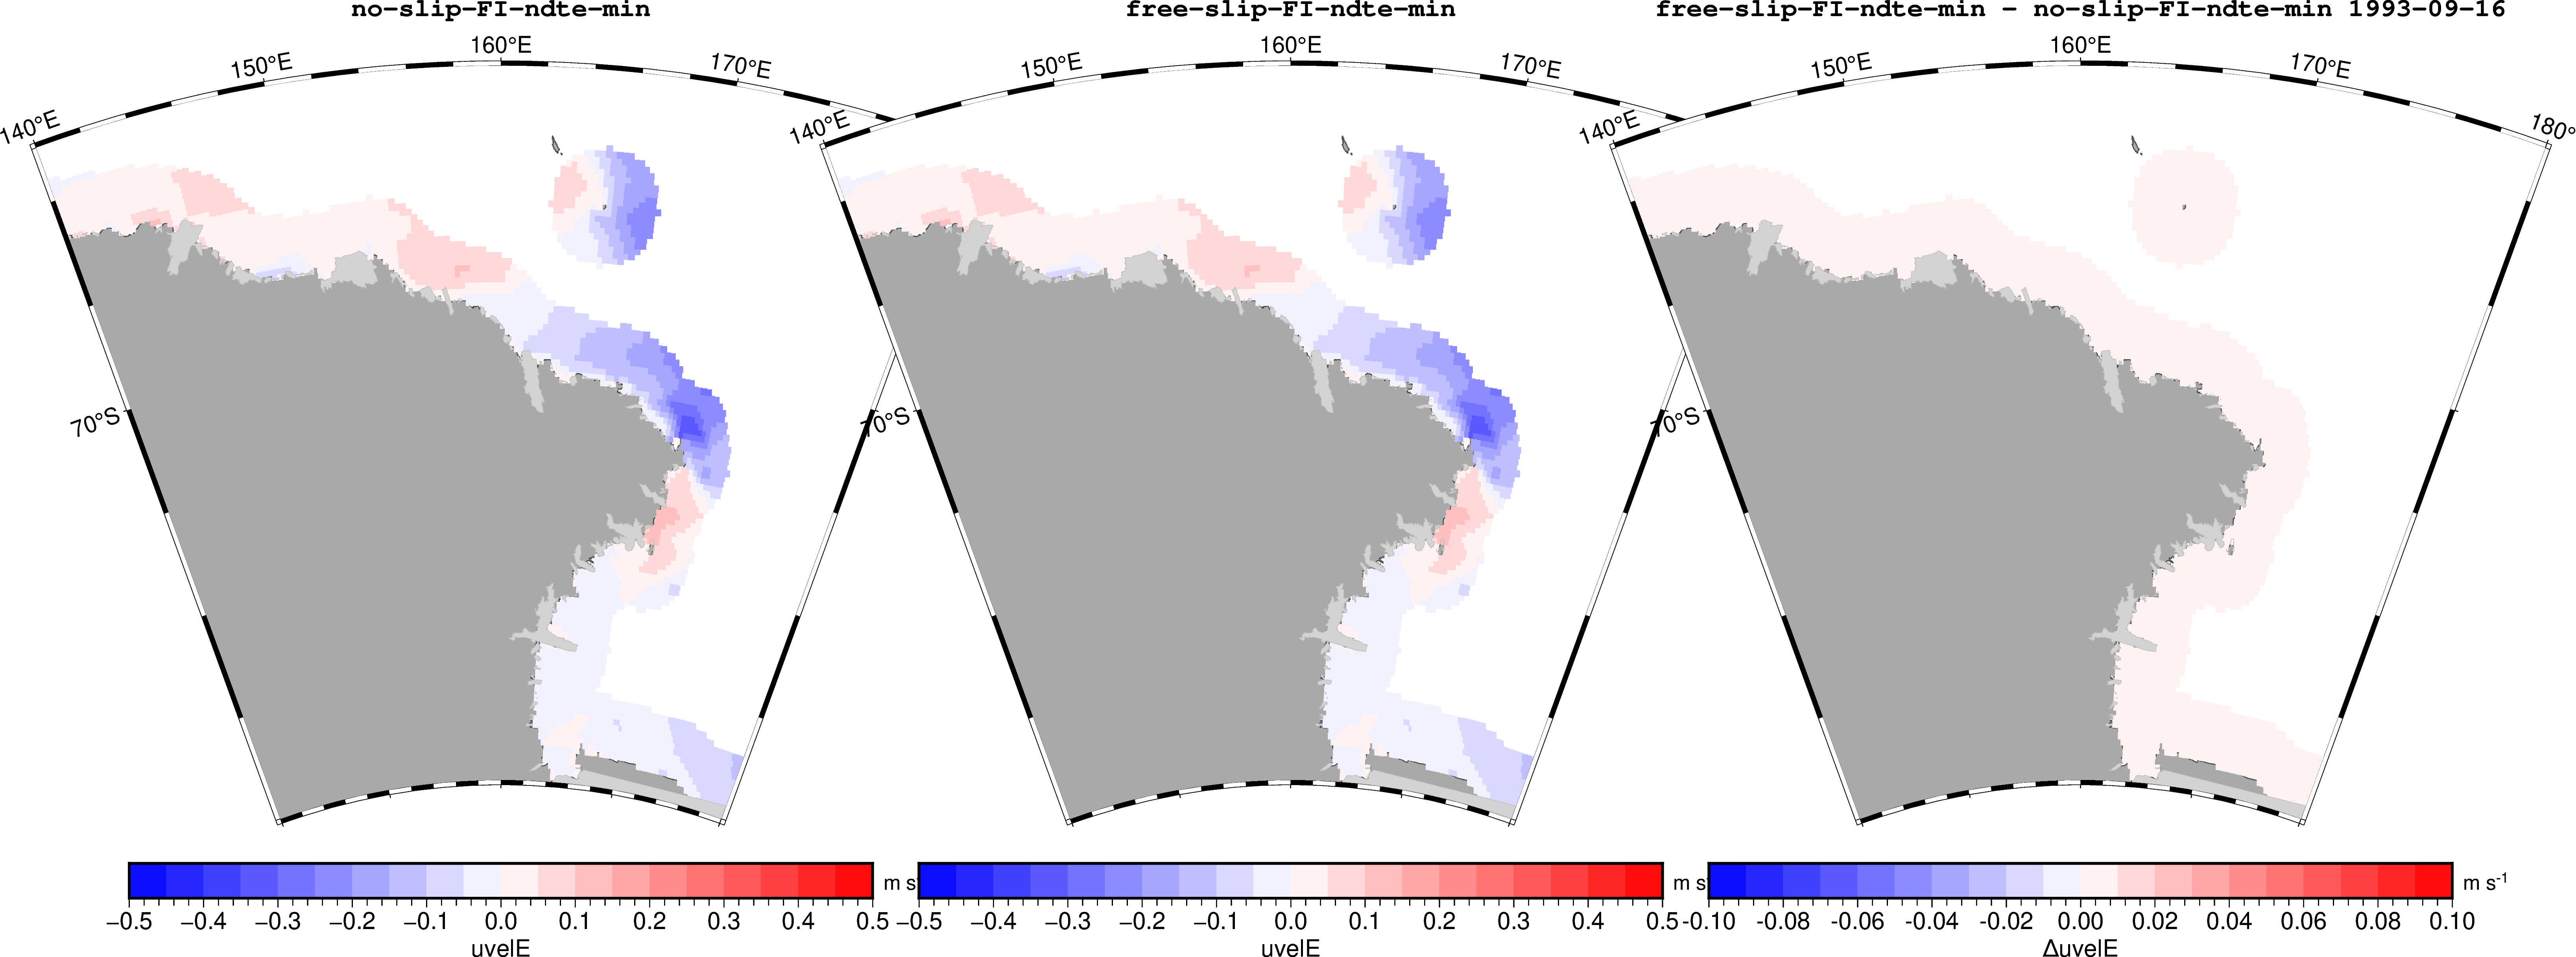

2026-01-07 16:53:43,509 - INFO - Saved figure to /g/data/gv90/da1339/GRAPHICAL/AFIM/no-slip-FI-ndte-min/AS/uvelE/1993-01-01_no-slip-FI-ndte-min_AS_uvelE.png


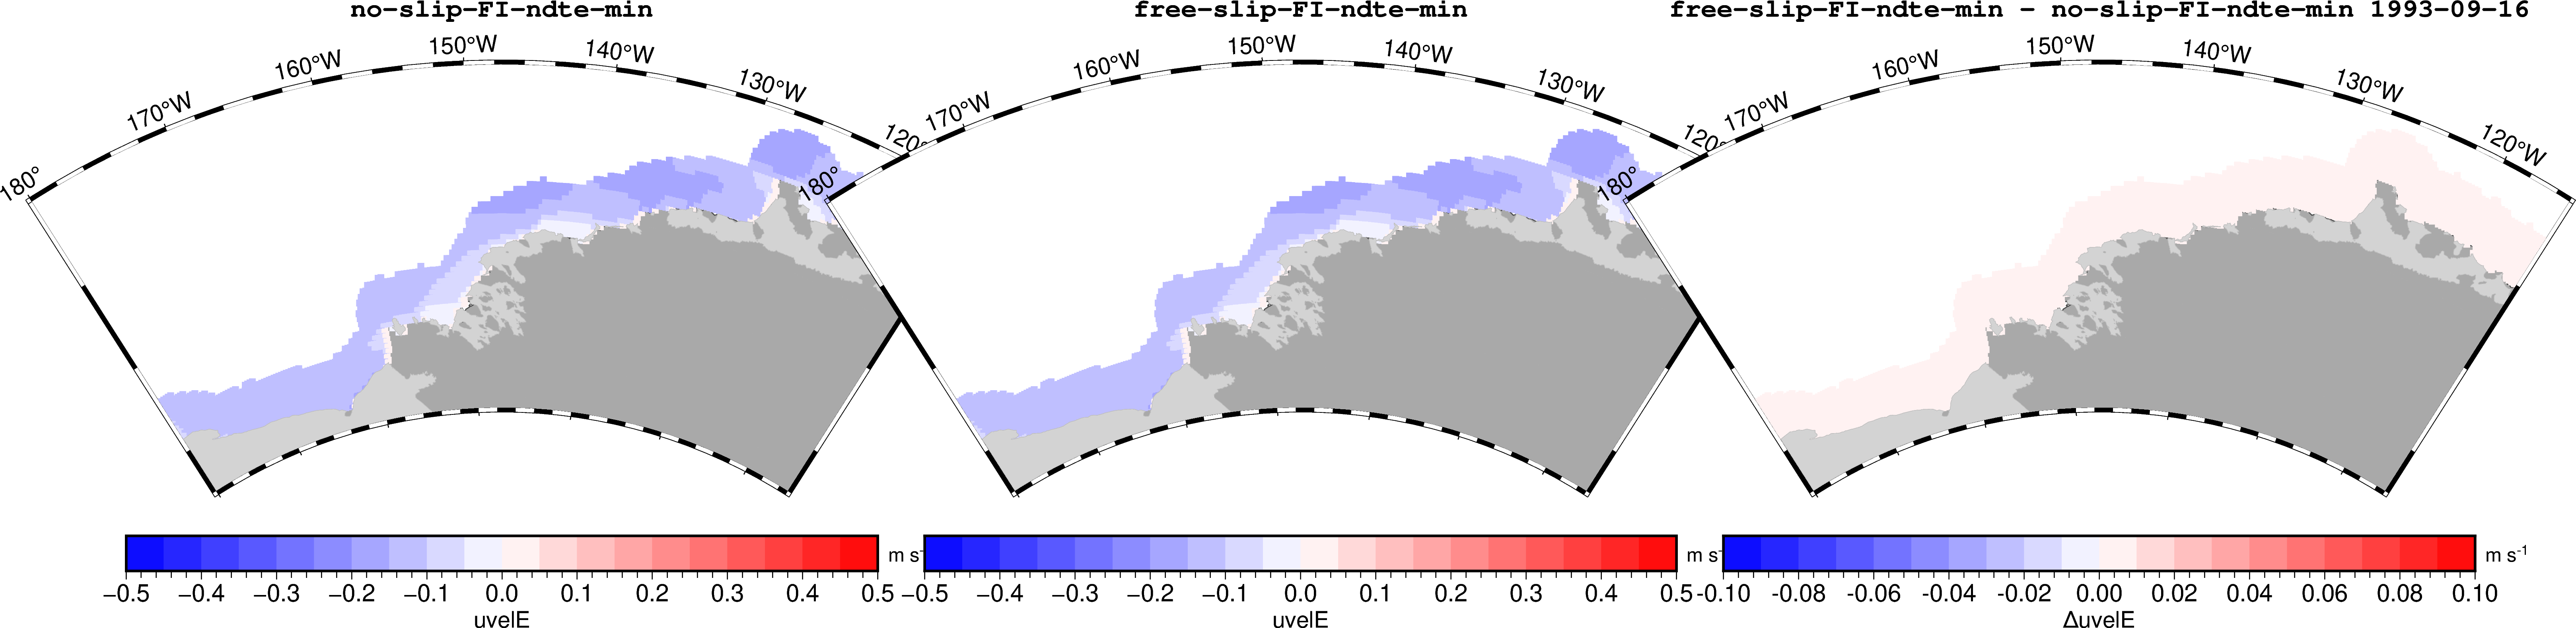

2026-01-07 16:53:50,961 - INFO - Saved figure to /g/data/gv90/da1339/GRAPHICAL/AFIM/no-slip-FI-ndte-min/BS/uvelE/1993-01-01_no-slip-FI-ndte-min_BS_uvelE.png


2026-01-07 16:53:59,078 - INFO - Saved figure to /g/data/gv90/da1339/GRAPHICAL/AFIM/no-slip-FI-ndte-min/WS/uvelE/1993-01-01_no-slip-FI-ndte-min_WS_uvelE.png


In [16]:
date_str = "1993-09-16"
u1       = ds1["uvelE"].where(cst_union).sel(time=date_str)#.compute()
u2       = ds1["uvelE"].where(cst_union).sel(time=date_str)#.load()
du       = (u2 - u1)
# tb1.pygmt_map_plot_one_var(u1,
#                            var_name="uvelE",
#                            sim_name=sim1,
#                            plot_regions = 8,
#                            plot_bathymetry=False,
#                            tit_str=f"uvelE {date_str}",
#                            cmap="cmocean/delta",                          # diverging
#                            series=[-.5,.5],
#                            reverse=False,                         # pass explicitly to avoid plot_var_dict lookup
#                            cbar_label="ice concentration difference",
#                            cbar_units="m/s",
#                            diff_plot=False,                       # keep False for continuous diffs
#                            use_tcoords=True,                      # required by prepare_data_for_pygmt_plot()
#                            overwrite_fig=True,
#                            show_fig=True)
# # Do this once outside your date loop
# cst_union_np = cst_union.compute().values.astype(bool)   # make it plain NumPy once

# # In the loop (per date):
# u1_da = ds1["uvelE"].sel(time=date_str)   # NO .where here
# u2_da = ds2["uvelE"].sel(time=date_str)

# # Compute both in one shot (parallelizes better than 2 sequential computes)
# u1_2d, u2_2d = xr.compute(u1_da.astype("float32"), u2_da.astype("float32"))
# u1_2d = u1_2d.values
# u2_2d = u2_2d.values

# # Apply mask after compute
# u1_2d = np.where(cst_union_np, u1_2d, np.nan)
# u2_2d = np.where(cst_union_np, u2_2d, np.nan)
# du_2d = u2_2d - u1_2d
tb1.pygmt_map_plot_multi_var_8sectors(das             = [u1, u2, du],
                                      var_names       = ["uvelE", "uvelE", "uvelE"],
                                      panel_titles    = [f"{sim1}", f"{sim2}", f"{sim2} − {sim1} {date_str}"],
                                      cmaps           = ["polar", "polar", "polar"],
                                      plot_bathymetry = False,
                                      plot_iceshelves = True,
                                      series_list     = [[-0.5, 0.5, 0.05], [-0.5, 0.5, 0.05], [-0.1, 0.1, 0.01]],
                                      reverse_list    = [False, False, False],
                                      cbar_labels     = ["uvelE", "uvelE", "ΔuvelE"],
                                      cbar_units_list = ["m s@+-1@+", "m s@+-1@+", "m s@+-1@+"],
                                      use_tcoords     = [True, True, True],
                                      var_out         = "uvelE",
                                      overwrite_fig   = True,
                                      show_fig        = True)

In [ ]:
year = 1995
months = [9, 10, 11]
ds1a, ds2a = xr.align(ds1, ds2, join="inner")
for m in months:
    # slice the month by time coordinate
    t0 = f"{year}-{m:02d}-01"
    t1 = f"{year}-{m:02d}-{pd.Period(t0).days_in_month:02d}"
    times = ds1a.time.sel(time=slice(t0, t1)).values
    for tt in times:
        # convert to YYYY-MM-DD string for labels + filenames
        date_str = pd.Timestamp(tt).strftime("%Y-%m-%d")
        u1 = ds1a["uvelE"].where(cst_union).sel(time=tt)
        u2 = ds2a["uvelE"].where(cst_union).sel(time=tt)
        du = u2 - u1
        tb1.pygmt_map_plot_multi_var_8sectors(das=[u1, u2, du],
            var_names=["uvelE", "uvelE", "uvelE"],
            panel_titles=[f"{sim1} {date_str}", f"{sim2}", f"{sim2} − {sim1}"],
            cmaps=["cmocean/delta", "cmocean/delta", "cmocean/delta"],
            plot_bathymetry=False,
            plot_iceshelves=True,
            series_list=[[-0.5, 0.5, 0.05], [-0.5, 0.5, 0.05], [-0.1, 0.1, 0.01]],
            reverse_list=[False, False, False],
            cbar_labels=["uvelE", "uvelE", "ΔuvelE"],
            cbar_units_list=["m s@+-1@+", "m s@+-1@+", "m s@+-1@+"],
            use_tcoords=[True, True, True],
            var_out="uvelE",
            overwrite_fig=True,
            show_fig=False,   # crucial for batch frame generation
        )

In [ ]:
# Load classified ice mask and data (SI has no binary-day or roll-mean association)
SI_cls  = SI_tools.load_classified_ice()['SI_mask']
CICE_SO = SI_tools.load_cice_zarr(slice_hem=True, variables=load_vars)
A       = CICE_SO['tarea'].isel(time=0)
# Apply the mask to the data
SI_msk  = CICE_SO.where(SI_cls)
# Create SI dictionary (daily-only; no binary-day association)
SI_ds   = SI_tools.sea_ice_metrics_data_dict(SI_cls, SI_msk, A)
# Compute metrics
P_mets_zarr = Path(SI_tools.D_zarr, SI_tools.hemisphere_dict['abbreviation'], f"{SI_tools.ice_type}_mets.zarr")
SI_tools.compute_sea_ice_metrics(SI_ds,
                                 P_mets_zarr    = P_mets_zarr,
                                 ice_area_scale = SI_tools.SIC_scale)

In [ ]:
sim_name1 = 'no-slip-FI-ndte-min'
sim_name2 = 'free-slip-FI-ndte-min'
P_log     = Path(Path.home(), "logs", f"SI_comparison_{sim_name1}_{sim_name2}.log")
SI_mgr    = SeaIceToolboxManager(P_log=P_log)
SI_tools  = SI_mgr.get_toolbox(sim_name = sim_name1,
                               ice_type = 'SI',
                               dt0_str  = "1993-01-01",
                               dtN_str  = "1993-12-31")
sim1_msk  = SI_tools.load_classified_ice()['SI_mask']
sim1_DS   = SI_tools.load_cice_zarr(slice_hem=True) # assumes 'SH'
sim1_mets = SI_tools.load_computed_metrics(spatial_grid_type=None) # loads daily (not roll-mean or bin-days)
SI_tools  = SI_mgr.get_toolbox(sim_name = sim_name2,
                               ice_type = 'SI',
                               dt0_str  = "1993-01-01",
                               dtN_str  = "1993-12-31")
sim2_msk  = SI_tools.load_classified_ice()['SI_mask']
sim2_DS   = SI_tools.load_cice_zarr(slice_hem=True) # assumes 'SH'
sim2_mets = SI_tools.load_computed_metrics(spatial_grid_type=None) # loads daily (not roll-mean or bin-days)

In [ ]:
sias, sivs, sits             = [], [], []
SIA_dict, SIV_dict, SIT_dict = {}, {}, {}
for sim_name in [sim_name1, sim_name2]:
    SI_tools = SI_mgr.get_toolbox(sim_name = sim_name, 
                                        dt0_str  = "1993-01-01",
                                        dtN_str  = "1993-12-31")
    so       = SI_tools.load_cice_zarr(slice_hem = True, variables = ["aice","hi","tarea"])
    sic      = so["aice"]  # [time, j, i] ...
    hi       = so["hi"]    # [time, j, i] ...
    A        = so["tarea"].isel(time=0).drop_vars("time", errors="ignore")  # [j, i]
    sia      = SI_tools.compute_hemisphere_ice_area(sic, A, ice_area_scale=SI_tools.SIC_scale)
    SIA_dict[sim_name] = {"SIA": sia}

In [ ]:
NSIDC_ts          = SI_tools.compute_NSIDC_metrics()
SIA_dict['NSIDC'] = {'SIA' : NSIDC_ts['SIA'].sel(time=slice("1993-01-01","1993-12-31"))}

In [ ]:
SI_tools.pygmt_timeseries(SIA_dict, 
                          comp_name   = "SH",
                          primary_key = "SIA",
                          climatology = True,
                          yaxis_pri   = "a2f1g5+lSea Ice Area (@[1\\times10^6\\ \\mathrm{km}^2@[)",
                          ylim        = [0,20],
                          show_fig    = True, 
                          legend_pos  = "JTL+jTL+o0.2c+w6.5c")

In [ ]:
SIA_dict['free-slip-FI-ndte-min']

In [ ]:
sim1_DS.isel(time=180)['aice'].plot()

In [ ]:
sim2_DS.isel(time=180)['aice'].plot()